# This is an Notebook which can evalute multiple files.  It implements a number of features:

- TopK
- Removing recent referrals
- Thresholding 
- Tables and visualization
- Config files for standardized processes. 



In [15]:
%reload_ext autoreload
%autoreload 2
#ignore warnings.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#imports
import pandas as pd
import os, sys
import importlib
import yaml, json
from pathlib import Path

#path append
sys.path.append(os.path.join(Path.cwd(), 'modules'))
import Evaluate, Helper, Present, Score, Synthetic


<H3> Imports</H3>

### File configuration
<p> Just edit the configuration file path/address. prediction_files contain configs for different prediction files. config_file contains other configs for referral, visualization, experiment etc. </p>

In [16]:
#multiple prediction file load still works, just loaded a single file because too many things are being displayed otherwise.
config_file = 'config/config.yaml'
#prediction_config_files = ['config/predictions/pred1.yaml', 'config/predictions/pred2.yaml']
prediction_config_files = ['config/predictions/pred1.yaml']
generate_data=True


### Load Configuration and Referrals

In [17]:
'''
Transferred referral data loading inside the c_p for loop below, because referral_data is being changed for date format adjustment. 
As referral_data.copy() is not allowed for memory issues. The overhead shouldn't be much.
'''

#Load Configuration
c_r, c_e, c_gen, c_aws, c_visual, predictions=Helper.load_configuration(config_file, prediction_config_files)

#Generate Data (if required)
if generate_data:
    Synthetic.generate_synthetic_event_data(c_gen)
    Synthetic.generate_synthetic_prediction_data(c_gen)

### Evaluate Models
For each configuration file provided it will evaluate the models. 

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201510-201607,201601,499,446.00000,50.00000,3.00000,0.00000,436.00000,60.00000,3.00000,0.00000,239.00000,257.00000,1.00000,2.00000,279.00000,217.00000,1.00000,2.00000,0.00000,0.00000,0.00772,0.00913,0.00000,0.00000,0.66667,0.66667,0.00000,0.00000,0.66667,0.66667,0.44960,0.43952,0.57426,0.61458,0.00000,0.00000,0.01527,0.01802,1.06484,0.67742,0.35288,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:00.033795-04:00,2020-06-09 14:00:00.079688-04:00,00:00:00.045893
1,Version 1.0,lin_reg,201601-201607,201601,499,446.00000,50.00000,3.00000,0.00000,436.00000,60.00000,3.00000,0.00000,239.00000,257.00000,1.00000,2.00000,279.00000,217.00000,1.00000,2.00000,0.00000,0.00000,0.00772,0.00913,0.00000,0.00000,0.66667,0.66667,0.00000,0.00000,0.66667,0.66667,0.44960,0.43952,0.57426,0.61458,0.00000,0.00000,0.01527,0.01802,1.06484,0.67742,0.35288,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:00.082656-04:00,2020-06-09 14:00:00.097616-04:00,00:00:00.014960
2,Version 1.0,rand_forest,201510-201607,201601,499,446.00000,50.00000,3.00000,0.00000,436.00000,60.00000,3.00000,0.00000,242.00000,254.00000,1.00000,2.00000,287.00000,209.00000,2.00000,1.00000,0.00000,0.00000,0.00781,0.00476,0.00000,0.00000,0.66667,0.33333,0.00000,0.00000,0.66667,0.33333,0.44960,0.43952,0.57728,0.45598,0.00000,0.00000,0.01544,0.00939,1.03633,0.37366,0.34200,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:00.098613-04:00,2020-06-09 14:00:00.112592-04:00,00:00:00.013979
3,Version 1.0,rand_forest,201601-201607,201601,499,446.00000,50.00000,3.00000,0.00000,436.00000,60.00000,3.00000,0.00000,242.00000,254.00000,1.00000,2.00000,287.00000,209.00000,2.00000,1.00000,0.00000,0.00000,0.00781,0.00476,0.00000,0.00000,0.66667,0.33333,0.00000,0.00000,0.66667,0.33333,0.44960,0.43952,0.57728,0.45598,0.00000,0.00000,0.01544,0.00939,1.03633,0.37366,0.34200,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:00.113572-04:00,2020-06-09 14:00:00.127549-04:00,00:00:00.013977
4,Version 1.0,xg_boost,201510-201607,201601,499,446.00000,50.00000,3.00000,0.00000,436.00000,60.00000,3.00000,0.00000,244.00000,252.00000,2.00000,1.00000,305.00000,191.00000,2.00000,1.00000,0.00000,0.00000,0.00395,0.00521,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000,0.33333,0.33333,0.44960,0.43952,0.41263,0.47413,0.00000,0.00000,0.00781,0.01026,0.95829,0.43280,0.33071,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:00.128531-04:00,2020-06-09 14:00:00.142493-04:00,00:00:00.013962
5,Version 1.0,xg_boost,201601-201607,201601,499,446.00000,50.00000,3.00000,0.00000,436.00000,60.00000,3.00000,0.00000,244.00000,252.00000,2.00000,1.00000,305.00000,191.00000,2.00000,1.00000,0.00000,0.00000,0.00395,0.00521,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000,0.33333,0.33333,0.44960,0.43952,0.41263,0.47413,0.00000,0.00000,0.00781,0.01026,0.95829,0.43280,0.33071,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201511-201608,201602,499,443.00000,50.00000,6.00000,0.00000,433.00000,60.00000,6.00000,0.00000,244.00000,249.00000,4.00000,2.00000,300.00000,193.00000,4.00000,2.00000,0.00000,0.00000,0.00797,0.01026,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000,0.33333,0.33333,0.44929,0.43915,0.41413,0.47093,0.00000,0.00000,0.01556,0.01990,0.97500,0.37627,0.32901,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:01.757660-04:00,2020-06-09 14:00:01.810516-04:00,00:00:00.052856
1,Version 1.0,lin_reg,201602-201608,201602,499,443.00000,50.00000,6.00000,0.00000,433.00000,60.00000,6.00000,0.00000,244.00000,249.00000,4.00000,2.00000,300.00000,193.00000,4.00000,2.00000,0.00000,0.00000,0.00797,0.01026,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000,0.33333,0.33333,0.44929,0.43915,0.41413,0.47093,0.00000,0.00000,0.01556,0.01990,0.97500,0.37627,0.32901,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:01.814506-04:00,2020-06-09 14:00:01.831459-04:00,00:00:00.016953
2,Version 1.0,rand_forest,201511-201608,201602,499,443.00000,50.00000,6.00000,0.00000,433.00000,60.00000,6.00000,0.00000,256.00000,237.00000,3.00000,3.00000,303.00000,190.00000,4.00000,2.00000,0.00000,0.00000,0.01250,0.01042,0.00000,0.00000,0.50000,0.33333,0.00000,0.00000,0.50000,0.33333,0.44929,0.43915,0.50963,0.47397,0.00000,0.00000,0.02439,0.02020,0.98569,0.36883,0.32667,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:01.832456-04:00,2020-06-09 14:00:01.850663-04:00,00:00:00.018207
3,Version 1.0,rand_forest,201602-201608,201602,499,443.00000,50.00000,6.00000,0.00000,433.00000,60.00000,6.00000,0.00000,256.00000,237.00000,3.00000,3.00000,303.00000,190.00000,4.00000,2.00000,0.00000,0.00000,0.01250,0.01042,0.00000,0.00000,0.50000,0.33333,0.00000,0.00000,0.50000,0.33333,0.44929,0.43915,0.50963,0.47397,0.00000,0.00000,0.02439,0.02020,0.98569,0.36883,0.32667,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:01.851661-04:00,2020-06-09 14:00:01.871372-04:00,00:00:00.019711
4,Version 1.0,xg_boost,201511-201608,201602,499,443.00000,50.00000,6.00000,0.00000,433.00000,60.00000,6.00000,0.00000,242.00000,251.00000,5.00000,1.00000,288.00000,205.00000,5.00000,1.00000,0.00000,0.00000,0.00397,0.00485,0.00000,0.00000,0.16667,0.16667,0.00000,0.00000,0.16667,0.16667,0.44929,0.43915,0.32877,0.37542,0.00000,0.00000,0.00775,0.00943,0.99408,0.29986,0.33544,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:01.872363-04:00,2020-06-09 14:00:01.887660-04:00,00:00:00.015297
5,Version 1.0,xg_boost,201602-201608,201602,499,443.00000,50.00000,6.00000,0.00000,433.00000,60.00000,6.00000,0.00000,242.00000,251.00000,5.00000,1.00000,288.00000,205.00000,5.00000,1.00000,0.00000,0.00000,0.00397,0.00485,0.00000,0.00000,0.16667,0.16667,0.00000,0.00000,0.16667,0.16667,0.44929,0.43915,0.32877,0.37542,0.00000,0.00000,0.00775,0.00943,0.99408,0.29986,0.33544,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201512-201609,201603,498,442.00000,50.00000,6.00000,0.00000,432.00000,60.00000,6.00000,0.00000,237.00000,255.00000,4.00000,2.00000,288.00000,204.00000,5.00000,1.00000,0.00000,0.00000,0.00778,0.00488,0.00000,0.00000,0.33333,0.16667,0.00000,0.00000,0.33333,0.16667,0.44919,0.43902,0.40752,0.37602,0.00000,0.00000,0.01521,0.00948,1.04957,0.38347,0.34471,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:03.438684-04:00,2020-06-09 14:00:03.486553-04:00,00:00:00.047869
1,Version 1.0,lin_reg,201603-201609,201603,498,442.00000,50.00000,6.00000,0.00000,432.00000,60.00000,6.00000,0.00000,237.00000,255.00000,4.00000,2.00000,288.00000,204.00000,5.00000,1.00000,0.00000,0.00000,0.00778,0.00488,0.00000,0.00000,0.33333,0.16667,0.00000,0.00000,0.33333,0.16667,0.44919,0.43902,0.40752,0.37602,0.00000,0.00000,0.01521,0.00948,1.04957,0.38347,0.34471,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:03.489545-04:00,2020-06-09 14:00:03.504517-04:00,00:00:00.014972
2,Version 1.0,rand_forest,201512-201609,201603,498,442.00000,50.00000,6.00000,0.00000,433.00000,59.00000,5.00000,1.00000,253.00000,239.00000,3.00000,3.00000,296.00000,196.00000,3.00000,3.00000,0.00000,0.01667,0.01240,0.01508,0.00000,0.16667,0.50000,0.50000,0.00000,0.16667,0.50000,0.50000,0.44919,0.52337,0.50711,0.55081,0.00000,0.03030,0.02419,0.02927,0.99961,0.51524,0.33515,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:03.505529-04:00,2020-06-09 14:00:03.520461-04:00,00:00:00.014932
3,Version 1.0,rand_forest,201603-201609,201603,498,442.00000,50.00000,6.00000,0.00000,433.00000,59.00000,5.00000,1.00000,253.00000,239.00000,3.00000,3.00000,296.00000,196.00000,3.00000,3.00000,0.00000,0.01667,0.01240,0.01508,0.00000,0.16667,0.50000,0.50000,0.00000,0.16667,0.50000,0.50000,0.44919,0.52337,0.50711,0.55081,0.00000,0.03030,0.02419,0.02927,0.99961,0.51524,0.33515,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:03.521457-04:00,2020-06-09 14:00:03.536441-04:00,00:00:00.014984
4,Version 1.0,xg_boost,201512-201609,201603,498,443.00000,49.00000,5.00000,1.00000,433.00000,59.00000,5.00000,1.00000,246.00000,246.00000,3.00000,3.00000,296.00000,196.00000,4.00000,2.00000,0.02000,0.01667,0.01205,0.01010,0.16667,0.16667,0.50000,0.33333,0.16667,0.16667,0.50000,0.33333,0.53354,0.52337,0.50000,0.46748,0.03571,0.03030,0.02353,0.01961,0.95363,0.47459,0.32648,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:03.537415-04:00,2020-06-09 14:00:03.552375-04:00,00:00:00.014960
5,Version 1.0,xg_boost,201603-201609,201603,498,443.00000,49.00000,5.00000,1.00000,433.00000,59.00000,5.00000,1.00000,246.00000,246.00000,3.00000,3.00000,296.00000,196.00000,4.00000,2.00000,0.02000,0.01667,0.01205,0.01010,0.16667,0.16667,0.50000,0.33333,0.16667,0.16667,0.50000,0.33333,0.53354,0.52337,0.50000,0.46748,0.03571,0.03030,0.02353,0.01961,0.95363,0.47459,0.32648,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201601-201610,201604,498,442.00000,50.00000,6.00000,0.00000,432.00000,60.00000,6.00000,0.00000,243.00000,249.00000,2.00000,4.00000,292.00000,200.00000,5.00000,1.00000,0.00000,0.00000,0.01581,0.00498,0.00000,0.00000,0.66667,0.16667,0.00000,0.00000,0.66667,0.16667,0.44919,0.43902,0.58028,0.38008,0.00000,0.00000,0.03089,0.00966,1.01368,0.52778,0.33467,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:05.518844-04:00,2020-06-09 14:00:05.570701-04:00,00:00:00.051857
1,Version 1.0,lin_reg,201604-201610,201604,498,442.00000,50.00000,6.00000,0.00000,432.00000,60.00000,6.00000,0.00000,243.00000,249.00000,2.00000,4.00000,292.00000,200.00000,5.00000,1.00000,0.00000,0.00000,0.01581,0.00498,0.00000,0.00000,0.66667,0.16667,0.00000,0.00000,0.66667,0.16667,0.44919,0.43902,0.58028,0.38008,0.00000,0.00000,0.03089,0.00966,1.01368,0.52778,0.33467,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:05.573693-04:00,2020-06-09 14:00:05.590648-04:00,00:00:00.016955
2,Version 1.0,rand_forest,201601-201610,201604,498,442.00000,50.00000,6.00000,0.00000,432.00000,60.00000,6.00000,0.00000,258.00000,234.00000,3.00000,3.00000,309.00000,183.00000,3.00000,3.00000,0.00000,0.00000,0.01266,0.01613,0.00000,0.00000,0.50000,0.50000,0.00000,0.00000,0.50000,0.50000,0.44919,0.43902,0.51220,0.56402,0.00000,0.00000,0.02469,0.03125,0.95621,0.52337,0.31715,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:05.591644-04:00,2020-06-09 14:00:05.607601-04:00,00:00:00.015957
3,Version 1.0,rand_forest,201604-201610,201604,498,442.00000,50.00000,6.00000,0.00000,432.00000,60.00000,6.00000,0.00000,258.00000,234.00000,3.00000,3.00000,309.00000,183.00000,3.00000,3.00000,0.00000,0.00000,0.01266,0.01613,0.00000,0.00000,0.50000,0.50000,0.00000,0.00000,0.50000,0.50000,0.44919,0.43902,0.51220,0.56402,0.00000,0.00000,0.02469,0.03125,0.95621,0.52337,0.31715,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:05.608598-04:00,2020-06-09 14:00:05.625551-04:00,00:00:00.016953
4,Version 1.0,xg_boost,201601-201610,201604,498,442.00000,50.00000,6.00000,0.00000,432.00000,60.00000,6.00000,0.00000,238.00000,254.00000,3.00000,3.00000,279.00000,213.00000,3.00000,3.00000,0.00000,0.00000,0.01167,0.01389,0.00000,0.00000,0.50000,0.50000,0.00000,0.00000,0.50000,0.50000,0.44919,0.43902,0.49187,0.53354,0.00000,0.00000,0.02281,0.02703,1.02920,0.51186,0.34886,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:05.626548-04:00,2020-06-09 14:00:05.642512-04:00,00:00:00.015964
5,Version 1.0,xg_boost,201604-201610,201604,498,442.00000,50.00000,6.00000,0.00000,432.00000,60.00000,6.00000,0.00000,238.00000,254.00000,3.00000,3.00000,279.00000,213.00000,3.00000,3.00000,0.00000,0.00000,0.01167,0.01389,0.00000,0.00000,0.50000,0.50000,0.00000,0.00000,0.50000,0.50000,0.44919,0.43902,0.49187,0.53354,0.00000,0.00000,0.02281,0.02703,1.02920,0.51186,0.34886,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201602-201611,201605,497,441.00000,50.00000,6.00000,0.00000,431.00000,60.00000,6.00000,0.00000,250.00000,241.00000,6.00000,0.00000,304.00000,187.00000,6.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.44908,0.43890,0.25458,0.30957,0.00000,0.00000,0.00000,0.00000,0.97942,0.35777,0.32590,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:06.808549-04:00,2020-06-09 14:00:06.848424-04:00,00:00:00.039875
1,Version 1.0,lin_reg,201605-201611,201605,497,441.00000,50.00000,6.00000,0.00000,431.00000,60.00000,6.00000,0.00000,250.00000,241.00000,6.00000,0.00000,304.00000,187.00000,6.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.44908,0.43890,0.25458,0.30957,0.00000,0.00000,0.00000,0.00000,0.97942,0.35777,0.32590,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:06.850430-04:00,2020-06-09 14:00:06.865384-04:00,00:00:00.014954
2,Version 1.0,rand_forest,201602-201611,201605,497,441.00000,50.00000,6.00000,0.00000,431.00000,60.00000,6.00000,0.00000,237.00000,254.00000,5.00000,1.00000,286.00000,205.00000,5.00000,1.00000,0.00000,0.00000,0.00392,0.00485,0.00000,0.00000,0.16667,0.16667,0.00000,0.00000,0.16667,0.16667,0.44908,0.43890,0.32468,0.37458,0.00000,0.00000,0.00766,0.00943,1.01507,0.26188,0.33901,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:06.865384-04:00,2020-06-09 14:00:06.878364-04:00,00:00:00.012980
3,Version 1.0,rand_forest,201605-201611,201605,497,441.00000,50.00000,6.00000,0.00000,431.00000,60.00000,6.00000,0.00000,237.00000,254.00000,5.00000,1.00000,286.00000,205.00000,5.00000,1.00000,0.00000,0.00000,0.00392,0.00485,0.00000,0.00000,0.16667,0.16667,0.00000,0.00000,0.16667,0.16667,0.44908,0.43890,0.32468,0.37458,0.00000,0.00000,0.00766,0.00943,1.01507,0.26188,0.33901,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:06.879336-04:00,2020-06-09 14:00:06.892305-04:00,00:00:00.012969
4,Version 1.0,xg_boost,201602-201611,201605,497,441.00000,50.00000,6.00000,0.00000,431.00000,60.00000,6.00000,0.00000,246.00000,245.00000,1.00000,5.00000,300.00000,191.00000,3.00000,3.00000,0.00000,0.00000,0.02000,0.01546,0.00000,0.00000,0.83333,0.50000,0.00000,0.00000,0.83333,0.50000,0.44908,0.43890,0.66718,0.55550,0.00000,0.00000,0.03906,0.03000,0.98744,0.66124,0.33091,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:06.893293-04:00,2020-06-09 14:00:06.906258-04:00,00:00:00.012965
5,Version 1.0,xg_boost,201605-201611,201605,497,441.00000,50.00000,6.00000,0.00000,431.00000,60.00000,6.00000,0.00000,246.00000,245.00000,1.00000,5.00000,300.00000,191.00000,3.00000,3.00000,0.00000,0.00000,0.02000,0.01546,0.00000,0.00000,0.83333,0.50000,0.00000,0.00000,0.83333,0.50000,0.44908,0.43890,0.66718,0.55550,0.00000,0.00000,0.03906,0.03000,0.98744,0.66124,0.33091,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201603-201612,201606,496,441.00000,50.00000,5.00000,0.00000,432.00000,59.00000,4.00000,1.00000,237.00000,254.00000,3.00000,2.00000,287.00000,204.00000,3.00000,2.00000,0.00000,0.01667,0.00781,0.00971,0.00000,0.20000,0.40000,0.40000,0.00000,0.20000,0.40000,0.40000,0.44908,0.53992,0.44134,0.49226,0.00000,0.03077,0.01533,0.01896,0.99491,0.51853,0.33651,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:08.177612-04:00,2020-06-09 14:00:08.217755-04:00,00:00:00.040143
1,Version 1.0,lin_reg,201606-201612,201606,496,441.00000,50.00000,5.00000,0.00000,432.00000,59.00000,4.00000,1.00000,237.00000,254.00000,3.00000,2.00000,287.00000,204.00000,3.00000,2.00000,0.00000,0.01667,0.00781,0.00971,0.00000,0.20000,0.40000,0.40000,0.00000,0.20000,0.40000,0.40000,0.44908,0.53992,0.44134,0.49226,0.00000,0.03077,0.01533,0.01896,0.99491,0.51853,0.33651,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:08.220763-04:00,2020-06-09 14:00:08.234009-04:00,00:00:00.013246
2,Version 1.0,rand_forest,201603-201612,201606,496,442.00000,49.00000,4.00000,1.00000,432.00000,59.00000,4.00000,1.00000,239.00000,252.00000,3.00000,2.00000,299.00000,192.00000,3.00000,2.00000,0.02000,0.01667,0.00787,0.01031,0.20000,0.20000,0.40000,0.40000,0.20000,0.20000,0.40000,0.40000,0.55010,0.53992,0.44338,0.50448,0.03636,0.03077,0.01544,0.02010,0.94912,0.42037,0.32930,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:08.235014-04:00,2020-06-09 14:00:08.247352-04:00,00:00:00.012338
3,Version 1.0,rand_forest,201606-201612,201606,496,442.00000,49.00000,4.00000,1.00000,432.00000,59.00000,4.00000,1.00000,239.00000,252.00000,3.00000,2.00000,299.00000,192.00000,3.00000,2.00000,0.02000,0.01667,0.00787,0.01031,0.20000,0.20000,0.40000,0.40000,0.20000,0.20000,0.40000,0.40000,0.55010,0.53992,0.44338,0.50448,0.03636,0.03077,0.01544,0.02010,0.94912,0.42037,0.32930,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:08.248285-04:00,2020-06-09 14:00:08.261516-04:00,00:00:00.013231
4,Version 1.0,xg_boost,201603-201612,201606,496,442.00000,49.00000,4.00000,1.00000,432.00000,59.00000,4.00000,1.00000,245.00000,246.00000,3.00000,2.00000,293.00000,198.00000,3.00000,2.00000,0.02000,0.01667,0.00806,0.01000,0.20000,0.20000,0.40000,0.40000,0.20000,0.20000,0.40000,0.40000,0.55010,0.53992,0.44949,0.49837,0.03636,0.03077,0.01581,0.01951,0.94510,0.51365,0.32423,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:08.261516-04:00,2020-06-09 14:00:08.273866-04:00,00:00:00.012350
5,Version 1.0,xg_boost,201606-201612,201606,496,442.00000,49.00000,4.00000,1.00000,432.00000,59.00000,4.00000,1.00000,245.00000,246.00000,3.00000,2.00000,293.00000,198.00000,3.00000,2.00000,0.02000,0.01667,0.00806,0.01000,0.20000,0.20000,0.40000,0.40000,0.20000,0.20000,0.40000,0.40000,0.55010,0.53992,0.44949,0.49837,0.03636,0.03077,0.01581,0.01951,0.94510,0.51365,0.32423,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201604-201701,201607,496,441.00000,49.00000,5.00000,1.00000,431.00000,59.00000,5.00000,1.00000,251.00000,239.00000,4.00000,2.00000,295.00000,195.00000,4.00000,2.00000,0.02000,0.01667,0.00830,0.01015,0.16667,0.16667,0.33333,0.33333,0.16667,0.16667,0.33333,0.33333,0.53333,0.52313,0.42279,0.46769,0.03571,0.03030,0.01619,0.01970,1.00901,0.45612,0.33368,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:09.447504-04:00,2020-06-09 14:00:09.490398-04:00,00:00:00.042894
1,Version 1.0,lin_reg,201607-201701,201607,496,441.00000,49.00000,5.00000,1.00000,431.00000,59.00000,5.00000,1.00000,251.00000,239.00000,4.00000,2.00000,295.00000,195.00000,4.00000,2.00000,0.02000,0.01667,0.00830,0.01015,0.16667,0.16667,0.33333,0.33333,0.16667,0.16667,0.33333,0.33333,0.53333,0.52313,0.42279,0.46769,0.03571,0.03030,0.01619,0.01970,1.00901,0.45612,0.33368,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:09.493390-04:00,2020-06-09 14:00:09.507351-04:00,00:00:00.013961
2,Version 1.0,rand_forest,201604-201701,201607,496,441.00000,49.00000,5.00000,1.00000,431.00000,59.00000,5.00000,1.00000,255.00000,235.00000,4.00000,2.00000,308.00000,182.00000,4.00000,2.00000,0.02000,0.01667,0.00844,0.01087,0.16667,0.16667,0.33333,0.33333,0.16667,0.16667,0.33333,0.33333,0.53333,0.52313,0.42687,0.48095,0.03571,0.03030,0.01646,0.02105,0.90987,0.56905,0.30925,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:09.508349-04:00,2020-06-09 14:00:09.522310-04:00,00:00:00.013961
3,Version 1.0,rand_forest,201607-201701,201607,496,441.00000,49.00000,5.00000,1.00000,431.00000,59.00000,5.00000,1.00000,255.00000,235.00000,4.00000,2.00000,308.00000,182.00000,4.00000,2.00000,0.02000,0.01667,0.00844,0.01087,0.16667,0.16667,0.33333,0.33333,0.16667,0.16667,0.33333,0.33333,0.53333,0.52313,0.42687,0.48095,0.03571,0.03030,0.01646,0.02105,0.90987,0.56905,0.30925,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:09.523308-04:00,2020-06-09 14:00:09.536272-04:00,00:00:00.012964
4,Version 1.0,xg_boost,201604-201701,201607,496,440.00000,50.00000,6.00000,0.00000,430.00000,60.00000,6.00000,0.00000,245.00000,245.00000,3.00000,3.00000,298.00000,192.00000,5.00000,1.00000,0.00000,0.00000,0.01210,0.00518,0.00000,0.00000,0.50000,0.16667,0.00000,0.00000,0.50000,0.16667,0.44898,0.43878,0.50000,0.38741,0.00000,0.00000,0.02362,0.01005,0.98305,0.36701,0.33291,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:09.537270-04:00,2020-06-09 14:00:09.550234-04:00,00:00:00.012964
5,Version 1.0,xg_boost,201607-201701,201607,496,440.00000,50.00000,6.00000,0.00000,430.00000,60.00000,6.00000,0.00000,245.00000,245.00000,3.00000,3.00000,298.00000,192.00000,5.00000,1.00000,0.00000,0.00000,0.01210,0.00518,0.00000,0.00000,0.50000,0.16667,0.00000,0.00000,0.50000,0.16667,0.44898,0.43878,0.50000,0.38741,0.00000,0.00000,0.02362,0.01005,0.98305,0.36701,0.33291,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201605-201702,201608,496,442.00000,48.00000,4.00000,2.00000,432.00000,58.00000,4.00000,2.00000,260.00000,230.00000,2.00000,4.00000,321.00000,169.00000,2.00000,4.00000,0.04000,0.03333,0.01709,0.02312,0.33333,0.33333,0.66667,0.66667,0.33333,0.33333,0.66667,0.66667,0.61769,0.60748,0.59864,0.66088,0.07143,0.06061,0.03333,0.04469,0.93363,0.62279,0.30957,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:10.768555-04:00,2020-06-09 14:00:10.810416-04:00,00:00:00.041861
1,Version 1.0,lin_reg,201608-201702,201608,496,442.00000,48.00000,4.00000,2.00000,432.00000,58.00000,4.00000,2.00000,260.00000,230.00000,2.00000,4.00000,321.00000,169.00000,2.00000,4.00000,0.04000,0.03333,0.01709,0.02312,0.33333,0.33333,0.66667,0.66667,0.33333,0.33333,0.66667,0.66667,0.61769,0.60748,0.59864,0.66088,0.07143,0.06061,0.03333,0.04469,0.93363,0.62279,0.30957,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:10.813408-04:00,2020-06-09 14:00:10.827370-04:00,00:00:00.013962
2,Version 1.0,rand_forest,201605-201702,201608,496,441.00000,49.00000,5.00000,1.00000,431.00000,59.00000,5.00000,1.00000,273.00000,217.00000,4.00000,2.00000,313.00000,177.00000,4.00000,2.00000,0.02000,0.01667,0.00913,0.01117,0.16667,0.16667,0.33333,0.33333,0.16667,0.16667,0.33333,0.33333,0.53333,0.52313,0.44524,0.48605,0.03571,0.03030,0.01778,0.02162,0.88498,0.48129,0.30083,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:10.828368-04:00,2020-06-09 14:00:10.840340-04:00,00:00:00.011972
3,Version 1.0,rand_forest,201608-201702,201608,496,441.00000,49.00000,5.00000,1.00000,431.00000,59.00000,5.00000,1.00000,273.00000,217.00000,4.00000,2.00000,313.00000,177.00000,4.00000,2.00000,0.02000,0.01667,0.00913,0.01117,0.16667,0.16667,0.33333,0.33333,0.16667,0.16667,0.33333,0.33333,0.53333,0.52313,0.44524,0.48605,0.03571,0.03030,0.01778,0.02162,0.88498,0.48129,0.30083,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:10.841352-04:00,2020-06-09 14:00:10.853314-04:00,00:00:00.011962
4,Version 1.0,xg_boost,201605-201702,201608,496,440.00000,50.00000,6.00000,0.00000,430.00000,60.00000,6.00000,0.00000,229.00000,261.00000,3.00000,3.00000,273.00000,217.00000,4.00000,2.00000,0.00000,0.00000,0.01136,0.00913,0.00000,0.00000,0.50000,0.33333,0.00000,0.00000,0.50000,0.33333,0.44898,0.43878,0.48367,0.44524,0.00000,0.00000,0.02222,0.01778,1.06175,0.44626,0.35622,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:10.854296-04:00,2020-06-09 14:00:10.867261-04:00,00:00:00.012965
5,Version 1.0,xg_boost,201608-201702,201608,496,440.00000,50.00000,6.00000,0.00000,430.00000,60.00000,6.00000,0.00000,229.00000,261.00000,3.00000,3.00000,273.00000,217.00000,4.00000,2.00000,0.00000,0.00000,0.01136,0.00913,0.00000,0.00000,0.50000,0.33333,0.00000,0.00000,0.50000,0.33333,0.44898,0.43878,0.48367,0.44524,0.00000,0.00000,0.02222,0.01778,1.06175,0.44626,0.35622,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201606-201703,201609,494,442.00000,49.00000,2.00000,1.00000,432.00000,59.00000,2.00000,1.00000,229.00000,262.00000,1.00000,2.00000,275.00000,216.00000,1.00000,2.00000,0.02000,0.01667,0.00758,0.00917,0.33333,0.33333,0.66667,0.66667,0.33333,0.33333,0.66667,0.66667,0.61677,0.60659,0.56653,0.61337,0.03774,0.03175,0.01498,0.01810,1.02902,0.60828,0.34567,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:12.256175-04:00,2020-06-09 14:00:12.294887-04:00,00:00:00.038712
1,Version 1.0,lin_reg,201609-201703,201609,494,442.00000,49.00000,2.00000,1.00000,432.00000,59.00000,2.00000,1.00000,229.00000,262.00000,1.00000,2.00000,275.00000,216.00000,1.00000,2.00000,0.02000,0.01667,0.00758,0.00917,0.33333,0.33333,0.66667,0.66667,0.33333,0.33333,0.66667,0.66667,0.61677,0.60659,0.56653,0.61337,0.03774,0.03175,0.01498,0.01810,1.02902,0.60828,0.34567,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:12.298084-04:00,2020-06-09 14:00:12.311608-04:00,00:00:00.013524
2,Version 1.0,rand_forest,201606-201703,201609,494,441.00000,50.00000,3.00000,0.00000,431.00000,60.00000,3.00000,0.00000,225.00000,266.00000,1.00000,2.00000,271.00000,220.00000,2.00000,1.00000,0.00000,0.00000,0.00746,0.00452,0.00000,0.00000,0.66667,0.33333,0.00000,0.00000,0.66667,0.33333,0.44908,0.43890,0.56246,0.44263,0.00000,0.00000,0.01476,0.00893,1.07645,0.47115,0.35639,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:12.311608-04:00,2020-06-09 14:00:12.323935-04:00,00:00:00.012327
3,Version 1.0,rand_forest,201609-201703,201609,494,441.00000,50.00000,3.00000,0.00000,431.00000,60.00000,3.00000,0.00000,225.00000,266.00000,1.00000,2.00000,271.00000,220.00000,2.00000,1.00000,0.00000,0.00000,0.00746,0.00452,0.00000,0.00000,0.66667,0.33333,0.00000,0.00000,0.66667,0.33333,0.44908,0.43890,0.56246,0.44263,0.00000,0.00000,0.01476,0.00893,1.07645,0.47115,0.35639,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:12.324917-04:00,2020-06-09 14:00:12.337424-04:00,00:00:00.012507
4,Version 1.0,xg_boost,201606-201703,201609,494,441.00000,50.00000,3.00000,0.00000,431.00000,60.00000,3.00000,0.00000,251.00000,240.00000,1.00000,2.00000,298.00000,193.00000,1.00000,2.00000,0.00000,0.00000,0.00826,0.01026,0.00000,0.00000,0.66667,0.66667,0.00000,0.00000,0.66667,0.66667,0.44908,0.43890,0.58893,0.63680,0.00000,0.00000,0.01633,0.02020,1.00953,0.58045,0.33704,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:12.338423-04:00,2020-06-09 14:00:12.350934-04:00,00:00:00.012511
5,Version 1.0,xg_boost,201609-201703,201609,494,441.00000,50.00000,3.00000,0.00000,431.00000,60.00000,3.00000,0.00000,251.00000,240.00000,1.00000,2.00000,298.00000,193.00000,1.00000,2.00000,0.00000,0.00000,0.00826,0.01026,0.00000,0.00000,0.66667,0.66667,0.00000,0.00000,0.66667,0.66667,0.44908,0.43890,0.58893,0.63680,0.00000,0.00000,0.01633,0.02020,1.00953,0.58045,0.33704,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201607-201704,201610,493,440.00000,48.00000,3.00000,2.00000,430.00000,58.00000,3.00000,2.00000,254.00000,234.00000,1.00000,4.00000,306.00000,182.00000,1.00000,4.00000,0.04000,0.03333,0.01681,0.02151,0.40000,0.40000,0.80000,0.80000,0.40000,0.40000,0.80000,0.80000,0.65082,0.64057,0.66025,0.71352,0.07273,0.06154,0.03292,0.04188,0.91864,0.75984,0.31182,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:13.594724-04:00,2020-06-09 14:00:13.635632-04:00,00:00:00.040908
1,Version 1.0,lin_reg,201610-201704,201610,493,440.00000,48.00000,3.00000,2.00000,430.00000,58.00000,3.00000,2.00000,254.00000,234.00000,1.00000,4.00000,306.00000,182.00000,1.00000,4.00000,0.04000,0.03333,0.01681,0.02151,0.40000,0.40000,0.80000,0.80000,0.40000,0.40000,0.80000,0.80000,0.65082,0.64057,0.66025,0.71352,0.07273,0.06154,0.03292,0.04188,0.91864,0.75984,0.31182,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:13.638627-04:00,2020-06-09 14:00:13.651573-04:00,00:00:00.012946
2,Version 1.0,rand_forest,201607-201704,201610,493,438.00000,50.00000,5.00000,0.00000,428.00000,60.00000,5.00000,0.00000,232.00000,256.00000,4.00000,1.00000,277.00000,211.00000,4.00000,1.00000,0.00000,0.00000,0.00389,0.00472,0.00000,0.00000,0.20000,0.20000,0.00000,0.00000,0.20000,0.20000,0.44877,0.43852,0.33770,0.38381,0.00000,0.00000,0.00763,0.00922,1.04146,0.31885,0.34914,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:13.651573-04:00,2020-06-09 14:00:13.665535-04:00,00:00:00.013962
3,Version 1.0,rand_forest,201610-201704,201610,493,438.00000,50.00000,5.00000,0.00000,428.00000,60.00000,5.00000,0.00000,232.00000,256.00000,4.00000,1.00000,277.00000,211.00000,4.00000,1.00000,0.00000,0.00000,0.00389,0.00472,0.00000,0.00000,0.20000,0.20000,0.00000,0.00000,0.20000,0.20000,0.44877,0.43852,0.33770,0.38381,0.00000,0.00000,0.00763,0.00922,1.04146,0.31885,0.34914,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:13.666539-04:00,2020-06-09 14:00:13.679493-04:00,00:00:00.012954
4,Version 1.0,xg_boost,201607-201704,201610,493,438.00000,50.00000,5.00000,0.00000,428.00000,60.00000,5.00000,0.00000,250.00000,238.00000,3.00000,2.00000,310.00000,178.00000,3.00000,2.00000,0.00000,0.00000,0.00833,0.01111,0.00000,0.00000,0.40000,0.40000,0.00000,0.00000,0.40000,0.40000,0.44877,0.43852,0.45615,0.51762,0.00000,0.00000,0.01633,0.02162,0.94756,0.46516,0.31759,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:13.680502-04:00,2020-06-09 14:00:13.694453-04:00,00:00:00.013951
5,Version 1.0,xg_boost,201610-201704,201610,493,438.00000,50.00000,5.00000,0.00000,428.00000,60.00000,5.00000,0.00000,250.00000,238.00000,3.00000,2.00000,310.00000,178.00000,3.00000,2.00000,0.00000,0.00000,0.00833,0.01111,0.00000,0.00000,0.40000,0.40000,0.00000,0.00000,0.40000,0.40000,0.44877,0.43852,0.45615,0.51762,0.00000,0.00000,0.01633,0.02162,0.94756,0.46516,0.31759,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201608-201705,201611,494,439.00000,50.00000,5.00000,0.00000,430.00000,59.00000,4.00000,1.00000,228.00000,261.00000,0.00000,5.00000,282.00000,207.00000,2.00000,3.00000,0.00000,0.01667,0.01880,0.01429,0.00000,0.20000,1.00000,0.60000,0.00000,0.20000,1.00000,0.60000,0.44888,0.53967,0.73313,0.58834,0.00000,0.03077,0.03690,0.02791,1.01565,0.64949,0.33995,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:14.982267-04:00,2020-06-09 14:00:15.026147-04:00,00:00:00.043880
1,Version 1.0,lin_reg,201611-201705,201611,494,439.00000,50.00000,5.00000,0.00000,430.00000,59.00000,4.00000,1.00000,228.00000,261.00000,0.00000,5.00000,282.00000,207.00000,2.00000,3.00000,0.00000,0.01667,0.01880,0.01429,0.00000,0.20000,1.00000,0.60000,0.00000,0.20000,1.00000,0.60000,0.44888,0.53967,0.73313,0.58834,0.00000,0.03077,0.03690,0.02791,1.01565,0.64949,0.33995,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:15.029139-04:00,2020-06-09 14:00:15.043101-04:00,00:00:00.013962
2,Version 1.0,rand_forest,201608-201705,201611,494,439.00000,50.00000,5.00000,0.00000,429.00000,60.00000,5.00000,0.00000,258.00000,231.00000,4.00000,1.00000,296.00000,193.00000,5.00000,0.00000,0.00000,0.00000,0.00431,0.00000,0.00000,0.00000,0.20000,0.00000,0.00000,0.00000,0.20000,0.00000,0.44888,0.43865,0.36380,0.30266,0.00000,0.00000,0.00844,0.00000,0.96724,0.40123,0.32323,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:15.044098-04:00,2020-06-09 14:00:15.058060-04:00,00:00:00.013962
3,Version 1.0,rand_forest,201611-201705,201611,494,439.00000,50.00000,5.00000,0.00000,429.00000,60.00000,5.00000,0.00000,258.00000,231.00000,4.00000,1.00000,296.00000,193.00000,5.00000,0.00000,0.00000,0.00000,0.00431,0.00000,0.00000,0.00000,0.20000,0.00000,0.00000,0.00000,0.20000,0.00000,0.44888,0.43865,0.36380,0.30266,0.00000,0.00000,0.00844,0.00000,0.96724,0.40123,0.32323,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:15.059078-04:00,2020-06-09 14:00:15.073019-04:00,00:00:00.013941
4,Version 1.0,xg_boost,201608-201705,201611,494,440.00000,49.00000,4.00000,1.00000,430.00000,59.00000,4.00000,1.00000,233.00000,256.00000,2.00000,3.00000,287.00000,202.00000,3.00000,2.00000,0.02000,0.01667,0.01158,0.00980,0.20000,0.20000,0.60000,0.40000,0.20000,0.20000,0.60000,0.40000,0.54990,0.53967,0.53824,0.49346,0.03636,0.03077,0.02273,0.01914,1.05893,0.50143,0.34841,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:15.074017-04:00,2020-06-09 14:00:15.087979-04:00,00:00:00.013962
5,Version 1.0,xg_boost,201611-201705,201611,494,440.00000,49.00000,4.00000,1.00000,430.00000,59.00000,4.00000,1.00000,233.00000,256.00000,2.00000,3.00000,287.00000,202.00000,3.00000,2.00000,0.02000,0.01667,0.01158,0.00980,0.20000,0.20000,0.60000,0.40000,0.20000,0.20000,0.60000,0.40000,0.54990,0.53967,0.53824,0.49346,0.03636,0.03077,0.02273,0.01914,1.05893,0.50143,0.34841,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201609-201706,201612,494,440.00000,50.00000,4.00000,0.00000,430.00000,60.00000,4.00000,0.00000,226.00000,264.00000,4.00000,0.00000,277.00000,213.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.44898,0.43878,0.23061,0.28265,0.00000,0.00000,0.00000,0.00000,1.06694,0.21684,0.36150,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:16.924041-04:00,2020-06-09 14:00:16.981883-04:00,00:00:00.057842
1,Version 1.0,lin_reg,201612-201706,201612,494,440.00000,50.00000,4.00000,0.00000,430.00000,60.00000,4.00000,0.00000,226.00000,264.00000,4.00000,0.00000,277.00000,213.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.44898,0.43878,0.23061,0.28265,0.00000,0.00000,0.00000,0.00000,1.06694,0.21684,0.36150,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:16.984875-04:00,2020-06-09 14:00:17.003823-04:00,00:00:00.018948
2,Version 1.0,rand_forest,201609-201706,201612,494,440.00000,50.00000,4.00000,0.00000,430.00000,60.00000,4.00000,0.00000,239.00000,251.00000,3.00000,1.00000,285.00000,205.00000,4.00000,0.00000,0.00000,0.00000,0.00397,0.00000,0.00000,0.00000,0.25000,0.00000,0.00000,0.00000,0.25000,0.00000,0.44898,0.43878,0.36888,0.29082,0.00000,0.00000,0.00781,0.00000,1.01512,0.37806,0.34741,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:17.003823-04:00,2020-06-09 14:00:17.022771-04:00,00:00:00.018948
3,Version 1.0,rand_forest,201612-201706,201612,494,440.00000,50.00000,4.00000,0.00000,430.00000,60.00000,4.00000,0.00000,239.00000,251.00000,3.00000,1.00000,285.00000,205.00000,4.00000,0.00000,0.00000,0.00000,0.00397,0.00000,0.00000,0.00000,0.25000,0.00000,0.00000,0.00000,0.25000,0.00000,0.44898,0.43878,0.36888,0.29082,0.00000,0.00000,0.00781,0.00000,1.01512,0.37806,0.34741,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:17.023769-04:00,2020-06-09 14:00:17.041719-04:00,00:00:00.017950
4,Version 1.0,xg_boost,201609-201706,201612,494,440.00000,50.00000,4.00000,0.00000,430.00000,60.00000,4.00000,0.00000,256.00000,234.00000,2.00000,2.00000,313.00000,177.00000,2.00000,2.00000,0.00000,0.00000,0.00847,0.01117,0.00000,0.00000,0.50000,0.50000,0.00000,0.00000,0.50000,0.50000,0.44898,0.43878,0.51122,0.56939,0.00000,0.00000,0.01667,0.02186,0.93021,0.54439,0.31620,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:17.042717-04:00,2020-06-09 14:00:17.060668-04:00,00:00:00.017951
5,Version 1.0,xg_boost,201612-201706,201612,494,440.00000,50.00000,4.00000,0.00000,430.00000,60.00000,4.00000,0.00000,256.00000,234.00000,2.00000,2.00000,313.00000,177.00000,2.00000,2.00000,0.00000,0.00000,0.00847,0.01117,0.00000,0.00000,0.50000,0.50000,0.00000,0.00000,0.50000,0.50000,0.44898,0.43878,0.51122,0.56939,0.00000,0.00000,0.01667,0.02186,0.93021,0.54439,0.31620,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201610-201707,201701,494,441.00000,49.00000,3.00000,1.00000,431.00000,59.00000,3.00000,1.00000,244.00000,246.00000,1.00000,3.00000,294.00000,196.00000,1.00000,3.00000,0.02000,0.01667,0.01205,0.01508,0.25000,0.25000,0.75000,0.75000,0.25000,0.25000,0.75000,0.75000,0.57500,0.56480,0.62398,0.67500,0.03704,0.03125,0.02372,0.02956,1.01242,0.60867,0.33752,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:18.716636-04:00,2020-06-09 14:00:18.779454-04:00,00:00:00.062818
1,Version 1.0,lin_reg,201701-201707,201701,494,441.00000,49.00000,3.00000,1.00000,431.00000,59.00000,3.00000,1.00000,244.00000,246.00000,1.00000,3.00000,294.00000,196.00000,1.00000,3.00000,0.02000,0.01667,0.01205,0.01508,0.25000,0.25000,0.75000,0.75000,0.25000,0.25000,0.75000,0.75000,0.57500,0.56480,0.62398,0.67500,0.03704,0.03125,0.02372,0.02956,1.01242,0.60867,0.33752,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:18.783453-04:00,2020-06-09 14:00:18.802392-04:00,00:00:00.018939
2,Version 1.0,rand_forest,201610-201707,201701,494,441.00000,49.00000,3.00000,1.00000,431.00000,59.00000,3.00000,1.00000,249.00000,241.00000,3.00000,1.00000,289.00000,201.00000,3.00000,1.00000,0.02000,0.01667,0.00413,0.00495,0.25000,0.25000,0.25000,0.25000,0.25000,0.25000,0.25000,0.25000,0.57500,0.56480,0.37908,0.41990,0.03704,0.03125,0.00813,0.00971,0.98256,0.36888,0.33307,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:18.803399-04:00,2020-06-09 14:00:18.823334-04:00,00:00:00.019935
3,Version 1.0,rand_forest,201701-201707,201701,494,441.00000,49.00000,3.00000,1.00000,431.00000,59.00000,3.00000,1.00000,249.00000,241.00000,3.00000,1.00000,289.00000,201.00000,3.00000,1.00000,0.02000,0.01667,0.00413,0.00495,0.25000,0.25000,0.25000,0.25000,0.25000,0.25000,0.25000,0.25000,0.57500,0.56480,0.37908,0.41990,0.03704,0.03125,0.00813,0.00971,0.98256,0.36888,0.33307,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:18.824345-04:00,2020-06-09 14:00:18.843278-04:00,00:00:00.018933
4,Version 1.0,xg_boost,201610-201707,201701,494,441.00000,49.00000,3.00000,1.00000,431.00000,59.00000,3.00000,1.00000,254.00000,236.00000,2.00000,2.00000,306.00000,184.00000,2.00000,2.00000,0.02000,0.01667,0.00840,0.01075,0.25000,0.25000,0.50000,0.50000,0.25000,0.25000,0.50000,0.50000,0.57500,0.56480,0.50918,0.56224,0.03704,0.03125,0.01653,0.02105,0.95964,0.64388,0.32115,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:18.844276-04:00,2020-06-09 14:00:18.865220-04:00,00:00:00.020944
5,Version 1.0,xg_boost,201701-201707,201701,494,441.00000,49.00000,3.00000,1.00000,431.00000,59.00000,3.00000,1.00000,254.00000,236.00000,2.00000,2.00000,306.00000,184.00000,2.00000,2.00000,0.02000,0.01667,0.00840,0.01075,0.25000,0.25000,0.50000,0.50000,0.25000,0.25000,0.50000,0.50000,0.57500,0.56480,0.50918,0.56224,0.03704,0.03125,0.01653,0.02105,0.95964,0.64388,0.32115,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201611-201708,201702,493,438.00000,50.00000,5.00000,0.00000,428.00000,60.00000,5.00000,0.00000,246.00000,242.00000,2.00000,3.00000,291.00000,197.00000,2.00000,3.00000,0.00000,0.00000,0.01224,0.01500,0.00000,0.00000,0.60000,0.60000,0.00000,0.00000,0.60000,0.60000,0.44877,0.43852,0.55205,0.59816,0.00000,0.00000,0.02400,0.02927,1.02153,0.48033,0.33649,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:20.542490-04:00,2020-06-09 14:00:20.605335-04:00,00:00:00.062845
1,Version 1.0,lin_reg,201702-201708,201702,493,438.00000,50.00000,5.00000,0.00000,428.00000,60.00000,5.00000,0.00000,246.00000,242.00000,2.00000,3.00000,291.00000,197.00000,2.00000,3.00000,0.00000,0.00000,0.01224,0.01500,0.00000,0.00000,0.60000,0.60000,0.00000,0.00000,0.60000,0.60000,0.44877,0.43852,0.55205,0.59816,0.00000,0.00000,0.02400,0.02927,1.02153,0.48033,0.33649,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:20.610326-04:00,2020-06-09 14:00:20.633261-04:00,00:00:00.022935
2,Version 1.0,rand_forest,201611-201708,201702,493,438.00000,50.00000,5.00000,0.00000,428.00000,60.00000,5.00000,0.00000,268.00000,220.00000,2.00000,3.00000,322.00000,166.00000,3.00000,2.00000,0.00000,0.00000,0.01345,0.01190,0.00000,0.00000,0.60000,0.40000,0.00000,0.00000,0.60000,0.40000,0.44877,0.43852,0.57459,0.52992,0.00000,0.00000,0.02632,0.02312,0.88647,0.57623,0.30052,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:20.634257-04:00,2020-06-09 14:00:20.657196-04:00,00:00:00.022939
3,Version 1.0,rand_forest,201702-201708,201702,493,438.00000,50.00000,5.00000,0.00000,428.00000,60.00000,5.00000,0.00000,268.00000,220.00000,2.00000,3.00000,322.00000,166.00000,3.00000,2.00000,0.00000,0.00000,0.01345,0.01190,0.00000,0.00000,0.60000,0.40000,0.00000,0.00000,0.60000,0.40000,0.44877,0.43852,0.57459,0.52992,0.00000,0.00000,0.02632,0.02312,0.88647,0.57623,0.30052,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:20.658193-04:00,2020-06-09 14:00:20.681760-04:00,00:00:00.023567
4,Version 1.0,xg_boost,201611-201708,201702,493,440.00000,48.00000,3.00000,2.00000,430.00000,58.00000,3.00000,2.00000,249.00000,239.00000,0.00000,5.00000,306.00000,182.00000,2.00000,3.00000,0.04000,0.03333,0.02049,0.01622,0.40000,0.40000,1.00000,0.60000,0.40000,0.40000,1.00000,0.60000,0.65082,0.64057,0.75512,0.61352,0.07273,0.06154,0.04016,0.03158,0.94740,0.81230,0.31501,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:20.682760-04:00,2020-06-09 14:00:20.706680-04:00,00:00:00.023920
5,Version 1.0,xg_boost,201702-201708,201702,493,440.00000,48.00000,3.00000,2.00000,430.00000,58.00000,3.00000,2.00000,249.00000,239.00000,0.00000,5.00000,306.00000,182.00000,2.00000,3.00000,0.04000,0.03333,0.02049,0.01622,0.40000,0.40000,1.00000,0.60000,0.40000,0.40000,1.00000,0.60000,0.65082,0.64057,0.75512,0.61352,0.07273,0.06154,0.04016,0.03158,0.94740,0.81230,0.31501,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201612-201709,201703,496,440.00000,50.00000,6.00000,0.00000,430.00000,60.00000,6.00000,0.00000,242.00000,248.00000,2.00000,4.00000,293.00000,197.00000,2.00000,4.00000,0.00000,0.00000,0.01587,0.01990,0.00000,0.00000,0.66667,0.66667,0.00000,0.00000,0.66667,0.66667,0.44898,0.43878,0.58027,0.63231,0.00000,0.00000,0.03101,0.03865,0.94699,0.62449,0.32162,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:22.378524-04:00,2020-06-09 14:00:22.435063-04:00,00:00:00.056539
1,Version 1.0,lin_reg,201703-201709,201703,496,440.00000,50.00000,6.00000,0.00000,430.00000,60.00000,6.00000,0.00000,242.00000,248.00000,2.00000,4.00000,293.00000,197.00000,2.00000,4.00000,0.00000,0.00000,0.01587,0.01990,0.00000,0.00000,0.66667,0.66667,0.00000,0.00000,0.66667,0.66667,0.44898,0.43878,0.58027,0.63231,0.00000,0.00000,0.03101,0.03865,0.94699,0.62449,0.32162,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:22.438076-04:00,2020-06-09 14:00:22.456016-04:00,00:00:00.017940
2,Version 1.0,rand_forest,201612-201709,201703,496,440.00000,50.00000,6.00000,0.00000,431.00000,59.00000,5.00000,1.00000,253.00000,237.00000,4.00000,2.00000,311.00000,179.00000,4.00000,2.00000,0.00000,0.01667,0.00837,0.01105,0.00000,0.16667,0.33333,0.33333,0.00000,0.16667,0.33333,0.33333,0.44898,0.52313,0.42483,0.48401,0.00000,0.03030,0.01633,0.02139,0.93192,0.47381,0.31634,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:22.457015-04:00,2020-06-09 14:00:22.473563-04:00,00:00:00.016548
3,Version 1.0,rand_forest,201703-201709,201703,496,440.00000,50.00000,6.00000,0.00000,431.00000,59.00000,5.00000,1.00000,253.00000,237.00000,4.00000,2.00000,311.00000,179.00000,4.00000,2.00000,0.00000,0.01667,0.00837,0.01105,0.00000,0.16667,0.33333,0.33333,0.00000,0.16667,0.33333,0.33333,0.44898,0.52313,0.42483,0.48401,0.00000,0.03030,0.01633,0.02139,0.93192,0.47381,0.31634,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:22.474547-04:00,2020-06-09 14:00:22.492619-04:00,00:00:00.018072
4,Version 1.0,xg_boost,201612-201709,201703,496,442.00000,48.00000,4.00000,2.00000,432.00000,58.00000,4.00000,2.00000,244.00000,246.00000,3.00000,3.00000,291.00000,199.00000,3.00000,3.00000,0.04000,0.03333,0.01205,0.01485,0.33333,0.33333,0.50000,0.50000,0.33333,0.33333,0.50000,0.50000,0.61769,0.60748,0.49898,0.54694,0.07143,0.06061,0.02353,0.02885,1.00624,0.50714,0.33706,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:22.493633-04:00,2020-06-09 14:00:22.511106-04:00,00:00:00.017473
5,Version 1.0,xg_boost,201703-201709,201703,496,442.00000,48.00000,4.00000,2.00000,432.00000,58.00000,4.00000,2.00000,244.00000,246.00000,3.00000,3.00000,291.00000,199.00000,3.00000,3.00000,0.04000,0.03333,0.01205,0.01485,0.33333,0.33333,0.50000,0.50000,0.33333,0.33333,0.50000,0.50000,0.61769,0.60748,0.49898,0.54694,0.07143,0.06061,0.02353,0.02885,1.00624,0.50714,0.33706,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201701-201710,201704,497,443.00000,48.00000,4.00000,2.00000,433.00000,58.00000,4.00000,2.00000,263.00000,228.00000,3.00000,3.00000,311.00000,180.00000,3.00000,3.00000,0.04000,0.03333,0.01299,0.01639,0.33333,0.33333,0.50000,0.50000,0.33333,0.33333,0.50000,0.50000,0.61779,0.60760,0.51782,0.56670,0.07143,0.06061,0.02532,0.03175,0.96311,0.57943,0.31665,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:24.263274-04:00,2020-06-09 14:00:24.318619-04:00,00:00:00.055345
1,Version 1.0,lin_reg,201704-201710,201704,497,443.00000,48.00000,4.00000,2.00000,433.00000,58.00000,4.00000,2.00000,263.00000,228.00000,3.00000,3.00000,311.00000,180.00000,3.00000,3.00000,0.04000,0.03333,0.01299,0.01639,0.33333,0.33333,0.50000,0.50000,0.33333,0.33333,0.50000,0.50000,0.61779,0.60760,0.51782,0.56670,0.07143,0.06061,0.02532,0.03175,0.96311,0.57943,0.31665,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:24.321823-04:00,2020-06-09 14:00:24.338932-04:00,00:00:00.017109
2,Version 1.0,rand_forest,201701-201710,201704,497,442.00000,49.00000,5.00000,1.00000,432.00000,59.00000,5.00000,1.00000,237.00000,254.00000,2.00000,4.00000,291.00000,200.00000,2.00000,4.00000,0.02000,0.01667,0.01550,0.01961,0.16667,0.16667,0.66667,0.66667,0.16667,0.16667,0.66667,0.66667,0.53344,0.52325,0.57468,0.62967,0.03571,0.03030,0.03030,0.03810,0.95774,0.64358,0.33170,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:24.340486-04:00,2020-06-09 14:00:24.357649-04:00,00:00:00.017163
3,Version 1.0,rand_forest,201704-201710,201704,497,442.00000,49.00000,5.00000,1.00000,432.00000,59.00000,5.00000,1.00000,237.00000,254.00000,2.00000,4.00000,291.00000,200.00000,2.00000,4.00000,0.02000,0.01667,0.01550,0.01961,0.16667,0.16667,0.66667,0.66667,0.16667,0.16667,0.66667,0.66667,0.53344,0.52325,0.57468,0.62967,0.03571,0.03030,0.03030,0.03810,0.95774,0.64358,0.33170,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:24.358651-04:00,2020-06-09 14:00:24.375909-04:00,00:00:00.017258
4,Version 1.0,xg_boost,201701-201710,201704,497,442.00000,49.00000,5.00000,1.00000,432.00000,59.00000,5.00000,1.00000,253.00000,238.00000,0.00000,6.00000,301.00000,190.00000,3.00000,3.00000,0.02000,0.01667,0.02459,0.01554,0.16667,0.16667,1.00000,0.50000,0.16667,0.16667,1.00000,0.50000,0.53344,0.52325,0.75764,0.55652,0.03571,0.03030,0.04800,0.03015,0.98153,0.68432,0.32645,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:24.376907-04:00,2020-06-09 14:00:24.394560-04:00,00:00:00.017653
5,Version 1.0,xg_boost,201704-201710,201704,497,442.00000,49.00000,5.00000,1.00000,432.00000,59.00000,5.00000,1.00000,253.00000,238.00000,0.00000,6.00000,301.00000,190.00000,3.00000,3.00000,0.02000,0.01667,0.02459,0.01554,0.16667,0.16667,1.00000,0.50000,0.16667,0.16667,1.00000,0.50000,0.53344,0.52325,0.75764,0.55652,0.03571,0.03030,0.04800,0.03015,0.98153,0.68432,0.32645,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201702-201711,201705,494,442.00000,49.00000,2.00000,1.00000,432.00000,59.00000,2.00000,1.00000,247.00000,244.00000,1.00000,2.00000,288.00000,203.00000,1.00000,2.00000,0.02000,0.01667,0.00813,0.00976,0.33333,0.33333,0.66667,0.66667,0.33333,0.33333,0.66667,0.66667,0.61677,0.60659,0.58486,0.62661,0.03774,0.03175,0.01606,0.01923,0.99514,0.64019,0.33702,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:25.922085-04:00,2020-06-09 14:00:25.964031-04:00,00:00:00.041946
1,Version 1.0,lin_reg,201705-201711,201705,494,442.00000,49.00000,2.00000,1.00000,432.00000,59.00000,2.00000,1.00000,247.00000,244.00000,1.00000,2.00000,288.00000,203.00000,1.00000,2.00000,0.02000,0.01667,0.00813,0.00976,0.33333,0.33333,0.66667,0.66667,0.33333,0.33333,0.66667,0.66667,0.61677,0.60659,0.58486,0.62661,0.03774,0.03175,0.01606,0.01923,0.99514,0.64019,0.33702,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:25.966828-04:00,2020-06-09 14:00:25.980031-04:00,00:00:00.013203
2,Version 1.0,rand_forest,201702-201711,201705,494,441.00000,50.00000,3.00000,0.00000,431.00000,60.00000,3.00000,0.00000,236.00000,255.00000,3.00000,0.00000,288.00000,203.00000,3.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.44908,0.43890,0.24033,0.29328,0.00000,0.00000,0.00000,0.00000,0.98485,0.29396,0.33695,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:25.981017-04:00,2020-06-09 14:00:25.994410-04:00,00:00:00.013393
3,Version 1.0,rand_forest,201705-201711,201705,494,441.00000,50.00000,3.00000,0.00000,431.00000,60.00000,3.00000,0.00000,236.00000,255.00000,3.00000,0.00000,288.00000,203.00000,3.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.44908,0.43890,0.24033,0.29328,0.00000,0.00000,0.00000,0.00000,0.98485,0.29396,0.33695,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:25.995414-04:00,2020-06-09 14:00:26.008799-04:00,00:00:00.013385
4,Version 1.0,xg_boost,201702-201711,201705,494,441.00000,50.00000,3.00000,0.00000,431.00000,60.00000,3.00000,0.00000,244.00000,247.00000,1.00000,2.00000,291.00000,200.00000,1.00000,2.00000,0.00000,0.00000,0.00803,0.00990,0.00000,0.00000,0.66667,0.66667,0.00000,0.00000,0.66667,0.66667,0.44908,0.43890,0.58181,0.62967,0.00000,0.00000,0.01587,0.01951,1.01508,0.50170,0.33605,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:26.008799-04:00,2020-06-09 14:00:26.022116-04:00,00:00:00.013317
5,Version 1.0,xg_boost,201705-201711,201705,494,441.00000,50.00000,3.00000,0.00000,431.00000,60.00000,3.00000,0.00000,244.00000,247.00000,1.00000,2.00000,291.00000,200.00000,1.00000,2.00000,0.00000,0.00000,0.00803,0.00990,0.00000,0.00000,0.66667,0.66667,0.00000,0.00000,0.66667,0.66667,0.44908,0.43890,0.58181,0.62967,0.00000,0.00000,0.01587,0.01951,1.01508,0.50170,0.33605,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201703-201712,201706,495,443.00000,49.00000,2.00000,1.00000,433.00000,59.00000,2.00000,1.00000,247.00000,245.00000,1.00000,2.00000,307.00000,185.00000,1.00000,2.00000,0.02000,0.01667,0.00810,0.01070,0.33333,0.33333,0.66667,0.66667,0.33333,0.33333,0.66667,0.66667,0.61687,0.60671,0.58435,0.64533,0.03774,0.03175,0.01600,0.02105,1.00736,0.58062,0.33504,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:27.201352-04:00,2020-06-09 14:00:27.241244-04:00,00:00:00.039892
1,Version 1.0,lin_reg,201706-201712,201706,495,443.00000,49.00000,2.00000,1.00000,433.00000,59.00000,2.00000,1.00000,247.00000,245.00000,1.00000,2.00000,307.00000,185.00000,1.00000,2.00000,0.02000,0.01667,0.00810,0.01070,0.33333,0.33333,0.66667,0.66667,0.33333,0.33333,0.66667,0.66667,0.61687,0.60671,0.58435,0.64533,0.03774,0.03175,0.01600,0.02105,1.00736,0.58062,0.33504,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:27.243258-04:00,2020-06-09 14:00:27.257208-04:00,00:00:00.013950
2,Version 1.0,rand_forest,201703-201712,201706,495,442.00000,50.00000,3.00000,0.00000,432.00000,60.00000,3.00000,0.00000,239.00000,253.00000,3.00000,0.00000,298.00000,194.00000,3.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.44919,0.43902,0.24289,0.30285,0.00000,0.00000,0.00000,0.00000,1.02284,0.19106,0.33876,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:27.258231-04:00,2020-06-09 14:00:27.271196-04:00,00:00:00.012965
3,Version 1.0,rand_forest,201706-201712,201706,495,442.00000,50.00000,3.00000,0.00000,432.00000,60.00000,3.00000,0.00000,239.00000,253.00000,3.00000,0.00000,298.00000,194.00000,3.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.44919,0.43902,0.24289,0.30285,0.00000,0.00000,0.00000,0.00000,1.02284,0.19106,0.33876,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:27.272182-04:00,2020-06-09 14:00:27.285124-04:00,00:00:00.012942
4,Version 1.0,xg_boost,201703-201712,201706,495,442.00000,50.00000,3.00000,0.00000,432.00000,60.00000,3.00000,0.00000,233.00000,259.00000,2.00000,1.00000,283.00000,209.00000,3.00000,0.00000,0.00000,0.00000,0.00385,0.00000,0.00000,0.00000,0.33333,0.00000,0.00000,0.00000,0.33333,0.00000,0.44919,0.43902,0.40346,0.28760,0.00000,0.00000,0.00760,0.00000,1.06578,0.36247,0.34974,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:27.286121-04:00,2020-06-09 14:00:27.300092-04:00,00:00:00.013971
5,Version 1.0,xg_boost,201706-201712,201706,495,442.00000,50.00000,3.00000,0.00000,432.00000,60.00000,3.00000,0.00000,233.00000,259.00000,2.00000,1.00000,283.00000,209.00000,3.00000,0.00000,0.00000,0.00000,0.00385,0.00000,0.00000,0.00000,0.33333,0.00000,0.00000,0.00000,0.33333,0.00000,0.44919,0.43902,0.40346,0.28760,0.00000,0.00000,0.00760,0.00000,1.06578,0.36247,0.34974,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201704-201801,201707,495,442.00000,50.00000,3.00000,0.00000,432.00000,60.00000,3.00000,0.00000,235.00000,257.00000,2.00000,1.00000,288.00000,204.00000,3.00000,0.00000,0.00000,0.00000,0.00388,0.00000,0.00000,0.00000,0.33333,0.00000,0.00000,0.00000,0.33333,0.00000,0.44919,0.43902,0.40549,0.29268,0.00000,0.00000,0.00766,0.00000,1.06097,0.27981,0.34953,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:28.484738-04:00,2020-06-09 14:00:28.524963-04:00,00:00:00.040225
1,Version 1.0,lin_reg,201707-201801,201707,495,442.00000,50.00000,3.00000,0.00000,432.00000,60.00000,3.00000,0.00000,235.00000,257.00000,2.00000,1.00000,288.00000,204.00000,3.00000,0.00000,0.00000,0.00000,0.00388,0.00000,0.00000,0.00000,0.33333,0.00000,0.00000,0.00000,0.33333,0.00000,0.44919,0.43902,0.40549,0.29268,0.00000,0.00000,0.00766,0.00000,1.06097,0.27981,0.34953,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:28.528202-04:00,2020-06-09 14:00:28.542472-04:00,00:00:00.014270
2,Version 1.0,rand_forest,201704-201801,201707,495,442.00000,50.00000,3.00000,0.00000,432.00000,60.00000,3.00000,0.00000,255.00000,237.00000,2.00000,1.00000,303.00000,189.00000,2.00000,1.00000,0.00000,0.00000,0.00420,0.00526,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000,0.33333,0.33333,0.44919,0.43902,0.42581,0.47459,0.00000,0.00000,0.00830,0.01036,0.98401,0.46477,0.32102,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:28.542472-04:00,2020-06-09 14:00:28.555752-04:00,00:00:00.013280
3,Version 1.0,rand_forest,201707-201801,201707,495,442.00000,50.00000,3.00000,0.00000,432.00000,60.00000,3.00000,0.00000,255.00000,237.00000,2.00000,1.00000,303.00000,189.00000,2.00000,1.00000,0.00000,0.00000,0.00420,0.00526,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000,0.33333,0.33333,0.44919,0.43902,0.42581,0.47459,0.00000,0.00000,0.00830,0.01036,0.98401,0.46477,0.32102,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:28.557001-04:00,2020-06-09 14:00:28.572280-04:00,00:00:00.015279
4,Version 1.0,xg_boost,201704-201801,201707,495,442.00000,50.00000,3.00000,0.00000,433.00000,59.00000,2.00000,1.00000,238.00000,254.00000,1.00000,2.00000,284.00000,208.00000,1.00000,2.00000,0.00000,0.01667,0.00781,0.00952,0.00000,0.33333,0.66667,0.66667,0.00000,0.33333,0.66667,0.66667,0.44919,0.60671,0.57520,0.62195,0.00000,0.03175,0.01544,0.01878,1.03836,0.64973,0.34412,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:28.572280-04:00,2020-06-09 14:00:28.585535-04:00,00:00:00.013255
5,Version 1.0,xg_boost,201707-201801,201707,495,442.00000,50.00000,3.00000,0.00000,433.00000,59.00000,2.00000,1.00000,238.00000,254.00000,1.00000,2.00000,284.00000,208.00000,1.00000,2.00000,0.00000,0.01667,0.00781,0.00952,0.00000,0.33333,0.66667,0.66667,0.00000,0.33333,0.66667,0.66667,0.44919,0.60671,0.57520,0.62195,0.00000,0.03175,0.01544,0.01878,1.03836,0.64973,0.34412,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201705-201802,201708,496,443.00000,50.00000,3.00000,0.00000,433.00000,60.00000,3.00000,0.00000,249.00000,244.00000,2.00000,1.00000,296.00000,197.00000,2.00000,1.00000,0.00000,0.00000,0.00408,0.00505,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000,0.33333,0.33333,0.44929,0.43915,0.41920,0.46687,0.00000,0.00000,0.00806,0.00995,1.00624,0.35159,0.33774,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:30.032262-04:00,2020-06-09 14:00:30.072678-04:00,00:00:00.040416
1,Version 1.0,lin_reg,201708-201802,201708,496,443.00000,50.00000,3.00000,0.00000,433.00000,60.00000,3.00000,0.00000,249.00000,244.00000,2.00000,1.00000,296.00000,197.00000,2.00000,1.00000,0.00000,0.00000,0.00408,0.00505,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000,0.33333,0.33333,0.44929,0.43915,0.41920,0.46687,0.00000,0.00000,0.00806,0.00995,1.00624,0.35159,0.33774,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:30.074666-04:00,2020-06-09 14:00:30.089069-04:00,00:00:00.014403
2,Version 1.0,rand_forest,201705-201802,201708,496,443.00000,50.00000,3.00000,0.00000,433.00000,60.00000,3.00000,0.00000,246.00000,247.00000,2.00000,1.00000,298.00000,195.00000,2.00000,1.00000,0.00000,0.00000,0.00403,0.00510,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000,0.33333,0.33333,0.44929,0.43915,0.41616,0.46890,0.00000,0.00000,0.00797,0.01005,1.00161,0.51116,0.33131,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:30.090065-04:00,2020-06-09 14:00:30.102002-04:00,00:00:00.011937
3,Version 1.0,rand_forest,201708-201802,201708,496,443.00000,50.00000,3.00000,0.00000,433.00000,60.00000,3.00000,0.00000,246.00000,247.00000,2.00000,1.00000,298.00000,195.00000,2.00000,1.00000,0.00000,0.00000,0.00403,0.00510,0.00000,0.00000,0.33333,0.33333,0.00000,0.00000,0.33333,0.33333,0.44929,0.43915,0.41616,0.46890,0.00000,0.00000,0.00797,0.01005,1.00161,0.51116,0.33131,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:30.102999-04:00,2020-06-09 14:00:30.116205-04:00,00:00:00.013206
4,Version 1.0,xg_boost,201705-201802,201708,496,444.00000,49.00000,2.00000,1.00000,434.00000,59.00000,2.00000,1.00000,250.00000,243.00000,1.00000,2.00000,298.00000,195.00000,1.00000,2.00000,0.02000,0.01667,0.00816,0.01015,0.33333,0.33333,0.66667,0.66667,0.33333,0.33333,0.66667,0.66667,0.61697,0.60683,0.58688,0.63556,0.03774,0.03175,0.01613,0.02000,0.98982,0.64097,0.32475,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:30.117205-04:00,2020-06-09 14:00:30.129443-04:00,00:00:00.012238
5,Version 1.0,xg_boost,201708-201802,201708,496,444.00000,49.00000,2.00000,1.00000,434.00000,59.00000,2.00000,1.00000,250.00000,243.00000,1.00000,2.00000,298.00000,195.00000,1.00000,2.00000,0.02000,0.01667,0.00816,0.01015,0.33333,0.33333,0.66667,0.66667,0.33333,0.33333,0.66667,0.66667,0.61697,0.60683,0.58688,0.63556,0.03774,0.03175,0.01613,0.02000,0.98982,0.64097,0.32475,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201706-201803,201709,494,443.00000,50.00000,1.00000,0.00000,433.00000,60.00000,1.00000,0.00000,239.00000,254.00000,0.00000,1.00000,292.00000,201.00000,0.00000,1.00000,0.00000,0.00000,0.00392,0.00495,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.44929,0.43915,0.74239,0.79615,0.00000,0.00000,0.00781,0.00985,0.99251,0.81744,0.33238,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:31.405273-04:00,2020-06-09 14:00:31.445164-04:00,00:00:00.039891
1,Version 1.0,lin_reg,201709-201803,201709,494,443.00000,50.00000,1.00000,0.00000,433.00000,60.00000,1.00000,0.00000,239.00000,254.00000,0.00000,1.00000,292.00000,201.00000,0.00000,1.00000,0.00000,0.00000,0.00392,0.00495,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.44929,0.43915,0.74239,0.79615,0.00000,0.00000,0.00781,0.00985,0.99251,0.81744,0.33238,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:31.448156-04:00,2020-06-09 14:00:31.461123-04:00,00:00:00.012967
2,Version 1.0,rand_forest,201706-201803,201709,494,443.00000,50.00000,1.00000,0.00000,433.00000,60.00000,1.00000,0.00000,246.00000,247.00000,1.00000,0.00000,294.00000,199.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.44929,0.43915,0.24949,0.29817,0.00000,0.00000,0.00000,0.00000,0.97754,0.32049,0.33147,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:31.461123-04:00,2020-06-09 14:00:31.475082-04:00,00:00:00.013959
3,Version 1.0,rand_forest,201709-201803,201709,494,443.00000,50.00000,1.00000,0.00000,433.00000,60.00000,1.00000,0.00000,246.00000,247.00000,1.00000,0.00000,294.00000,199.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.44929,0.43915,0.24949,0.29817,0.00000,0.00000,0.00000,0.00000,0.97754,0.32049,0.33147,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:31.475082-04:00,2020-06-09 14:00:31.487075-04:00,00:00:00.011993
4,Version 1.0,xg_boost,201706-201803,201709,494,443.00000,50.00000,1.00000,0.00000,433.00000,60.00000,1.00000,0.00000,238.00000,255.00000,0.00000,1.00000,286.00000,207.00000,0.00000,1.00000,0.00000,0.00000,0.00391,0.00481,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.44929,0.43915,0.74138,0.79006,0.00000,0.00000,0.00778,0.00957,1.00279,0.73022,0.34082,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:31.488057-04:00,2020-06-09 14:00:31.500099-04:00,00:00:00.012042
5,Version 1.0,xg_boost,201709-201803,201709,494,443.00000,50.00000,1.00000,0.00000,433.00000,60.00000,1.00000,0.00000,238.00000,255.00000,0.00000,1.00000,286.00000,207.00000,0.00000,1.00000,0.00000,0.00000,0.00391,0.00481,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.44929,0.43915,0.74138,0.79006,0.00000,0.00000,0.00778,0.00957,1.00279,0.73022,0.34082,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201707-201804,201710,493,443.00000,50.00000,0.00000,0.00000,433.00000,60.00000,0.00000,0.00000,243.00000,250.00000,0.00000,0.00000,306.00000,187.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89858,0.87830,0.49290,0.62069,0.00000,0.00000,0.00000,0.00000,0.97385,0.00000,0.32229,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:32.627291-04:00,2020-06-09 14:00:32.669455-04:00,00:00:00.042164
1,Version 1.0,lin_reg,201710-201804,201710,493,443.00000,50.00000,0.00000,0.00000,433.00000,60.00000,0.00000,0.00000,243.00000,250.00000,0.00000,0.00000,306.00000,187.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89858,0.87830,0.49290,0.62069,0.00000,0.00000,0.00000,0.00000,0.97385,0.00000,0.32229,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:32.671829-04:00,2020-06-09 14:00:32.686579-04:00,00:00:00.014750
2,Version 1.0,rand_forest,201707-201804,201710,493,443.00000,50.00000,0.00000,0.00000,433.00000,60.00000,0.00000,0.00000,250.00000,243.00000,0.00000,0.00000,294.00000,199.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89858,0.87830,0.50710,0.59635,0.00000,0.00000,0.00000,0.00000,0.98923,0.00000,0.33248,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:32.687574-04:00,2020-06-09 14:00:32.703091-04:00,00:00:00.015517
3,Version 1.0,rand_forest,201710-201804,201710,493,443.00000,50.00000,0.00000,0.00000,433.00000,60.00000,0.00000,0.00000,250.00000,243.00000,0.00000,0.00000,294.00000,199.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89858,0.87830,0.50710,0.59635,0.00000,0.00000,0.00000,0.00000,0.98923,0.00000,0.33248,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:32.704086-04:00,2020-06-09 14:00:32.719309-04:00,00:00:00.015223
4,Version 1.0,xg_boost,201707-201804,201710,493,443.00000,50.00000,0.00000,0.00000,433.00000,60.00000,0.00000,0.00000,246.00000,247.00000,0.00000,0.00000,298.00000,195.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89858,0.87830,0.49899,0.60446,0.00000,0.00000,0.00000,0.00000,0.97613,0.00000,0.32795,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:32.720318-04:00,2020-06-09 14:00:32.737317-04:00,00:00:00.016999
5,Version 1.0,xg_boost,201710-201804,201710,493,443.00000,50.00000,0.00000,0.00000,433.00000,60.00000,0.00000,0.00000,246.00000,247.00000,0.00000,0.00000,298.00000,195.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89858,0.87830,0.49899,0.60446,0.00000,0.00000,0.00000,0.00000,0.97613,0.00000,0.32795,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201708-201805,201711,496,446.00000,50.00000,0.00000,0.00000,436.00000,60.00000,0.00000,0.00000,256.00000,240.00000,0.00000,0.00000,304.00000,192.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89919,0.87903,0.51613,0.61290,0.00000,0.00000,0.00000,0.00000,0.92696,0.00000,0.31789,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:34.001511-04:00,2020-06-09 14:00:34.049495-04:00,00:00:00.047984
1,Version 1.0,lin_reg,201711-201805,201711,496,446.00000,50.00000,0.00000,0.00000,436.00000,60.00000,0.00000,0.00000,256.00000,240.00000,0.00000,0.00000,304.00000,192.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89919,0.87903,0.51613,0.61290,0.00000,0.00000,0.00000,0.00000,0.92696,0.00000,0.31789,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:34.051484-04:00,2020-06-09 14:00:34.065448-04:00,00:00:00.013964
2,Version 1.0,rand_forest,201708-201805,201711,496,446.00000,50.00000,0.00000,0.00000,436.00000,60.00000,0.00000,0.00000,238.00000,258.00000,0.00000,0.00000,289.00000,207.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89919,0.87903,0.47984,0.58266,0.00000,0.00000,0.00000,0.00000,1.01762,0.00000,0.33770,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:34.066450-04:00,2020-06-09 14:00:34.079403-04:00,00:00:00.012953
3,Version 1.0,rand_forest,201711-201805,201711,496,446.00000,50.00000,0.00000,0.00000,436.00000,60.00000,0.00000,0.00000,238.00000,258.00000,0.00000,0.00000,289.00000,207.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89919,0.87903,0.47984,0.58266,0.00000,0.00000,0.00000,0.00000,1.01762,0.00000,0.33770,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:34.080403-04:00,2020-06-09 14:00:34.093365-04:00,00:00:00.012962
4,Version 1.0,xg_boost,201708-201805,201711,496,446.00000,50.00000,0.00000,0.00000,436.00000,60.00000,0.00000,0.00000,252.00000,244.00000,0.00000,0.00000,304.00000,192.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89919,0.87903,0.50806,0.61290,0.00000,0.00000,0.00000,0.00000,0.99060,0.00000,0.33110,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:34.094369-04:00,2020-06-09 14:00:34.106346-04:00,00:00:00.011977
5,Version 1.0,xg_boost,201711-201805,201711,496,446.00000,50.00000,0.00000,0.00000,436.00000,60.00000,0.00000,0.00000,252.00000,244.00000,0.00000,0.00000,304.00000,192.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89919,0.87903,0.50806,0.61290,0.00000,0.00000,0.00000,0.00000,0.99060,0.00000,0.33110,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

,Experiment Name,Model,Window,Eval Date,Num Samples,TN_@k=50,FP_@k=50,FN_@k=50,TP_@k=50,TN_@k=60,FP_@k=60,FN_@k=60,TP_@k=60,TN_@p>=0.5,FP_@p>=0.5,FN_@p>=0.5,TP_@p>=0.5,TN_@p>=0.6,FP_@p>=0.6,FN_@p>=0.6,TP_@p>=0.6,precision_@k=50,precision_@k=60,precision_@p>=0.5,precision_@p>=0.6,recall_@k=50,recall_@k=60,recall_@p>=0.5,recall_@p>=0.6,accuracy_@k=50,accuracy_@k=60,accuracy_@p>=0.5,accuracy_@p>=0.6,balanced_acc_@k=50,balanced_acc_@k=60,balanced_acc_@p>=0.5,balanced_acc_@p>=0.6,f1_score_@k=50,f1_score_@k=60,f1_score_@p>=0.5,f1_score_@p>=0.6,log_loss,roc_auc_score,brier_score_loss,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,201709-201806,201712,496,446.00000,50.00000,0.00000,0.00000,436.00000,60.00000,0.00000,0.00000,237.00000,259.00000,0.00000,0.00000,303.00000,193.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89919,0.87903,0.47782,0.61089,0.00000,0.00000,0.00000,0.00000,0.99847,0.00000,0.33520,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:35.315253-04:00,2020-06-09 14:00:35.352152-04:00,00:00:00.036899
1,Version 1.0,lin_reg,201712-201806,201712,496,446.00000,50.00000,0.00000,0.00000,436.00000,60.00000,0.00000,0.00000,237.00000,259.00000,0.00000,0.00000,303.00000,193.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89919,0.87903,0.47782,0.61089,0.00000,0.00000,0.00000,0.00000,0.99847,0.00000,0.33520,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:35.355144-04:00,2020-06-09 14:00:35.367111-04:00,00:00:00.011967
2,Version 1.0,rand_forest,201709-201806,201712,496,446.00000,50.00000,0.00000,0.00000,436.00000,60.00000,0.00000,0.00000,269.00000,227.00000,0.00000,0.00000,312.00000,184.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89919,0.87903,0.54234,0.62903,0.00000,0.00000,0.00000,0.00000,0.96828,0.00000,0.31918,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:35.368109-04:00,2020-06-09 14:00:35.380076-04:00,00:00:00.011967
3,Version 1.0,rand_forest,201712-201806,201712,496,446.00000,50.00000,0.00000,0.00000,436.00000,60.00000,0.00000,0.00000,269.00000,227.00000,0.00000,0.00000,312.00000,184.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89919,0.87903,0.54234,0.62903,0.00000,0.00000,0.00000,0.00000,0.96828,0.00000,0.31918,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:35.382072-04:00,2020-06-09 14:00:35.401019-04:00,00:00:00.018947
4,Version 1.0,xg_boost,201709-201806,201712,496,446.00000,50.00000,0.00000,0.00000,436.00000,60.00000,0.00000,0.00000,239.00000,257.00000,0.00000,0.00000,289.00000,207.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89919,0.87903,0.48185,0.58266,0.00000,0.00000,0.00000,0.00000,1.02856,0.00000,0.34449,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referrals.csv,./results/results.csv,2020-06-09 14:00:35.402016-04:00,2020-06-09 14:00:35.420966-04:00,00:00:00.018950
5,Version 1.0,xg_boost,201712-201806,201712,496,446.00000,50.00000,0.00000,0.00000,436.00000,60.00000,0.00000,0.00000,239.00000,257.00000,0.00000,0.00000,289.00000,207.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.89919,0.87903,0.48185,0.58266,0.00000,0.00000,0.00000,0.00000,1.02856,0.00000,0.34449,./data/simulated_prediction_data/predictions.csv,./data/simulated_prediction_data/referra

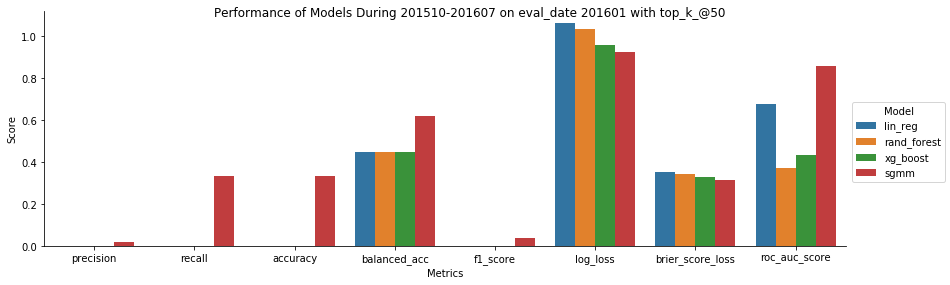

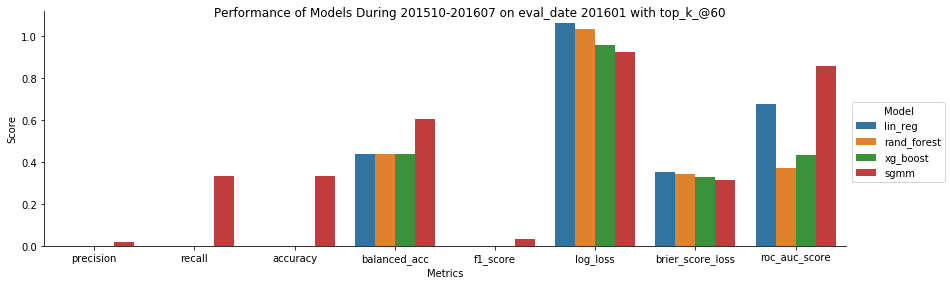

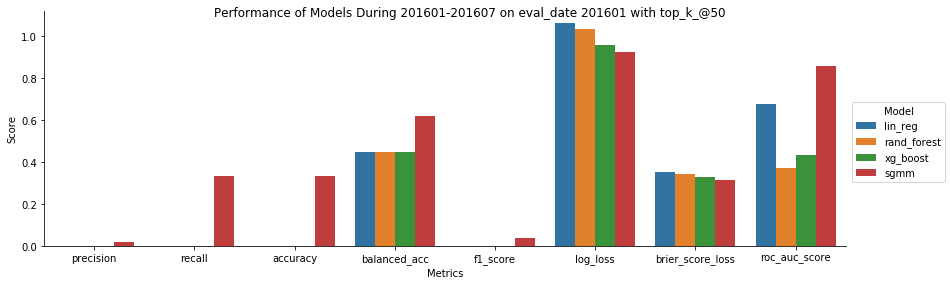

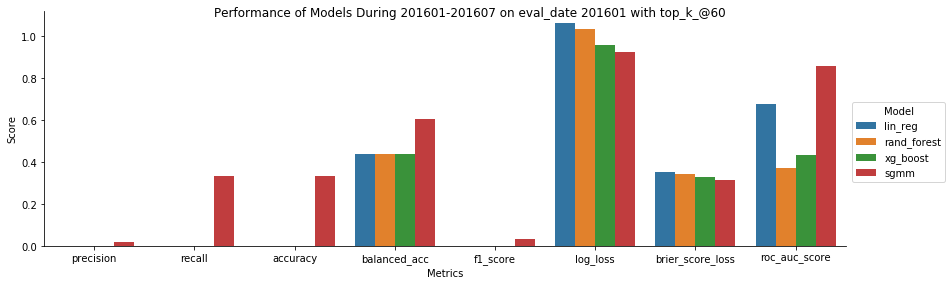

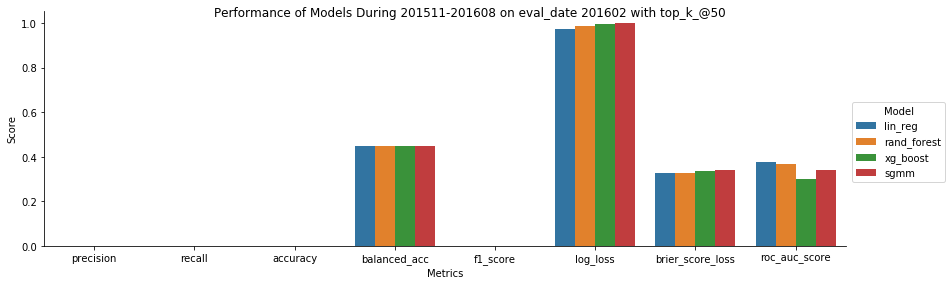

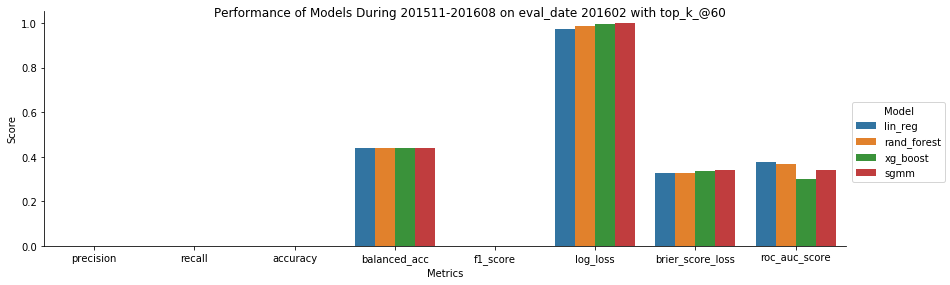

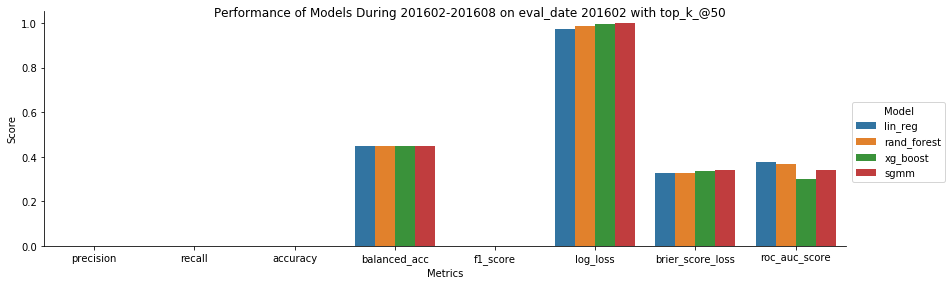

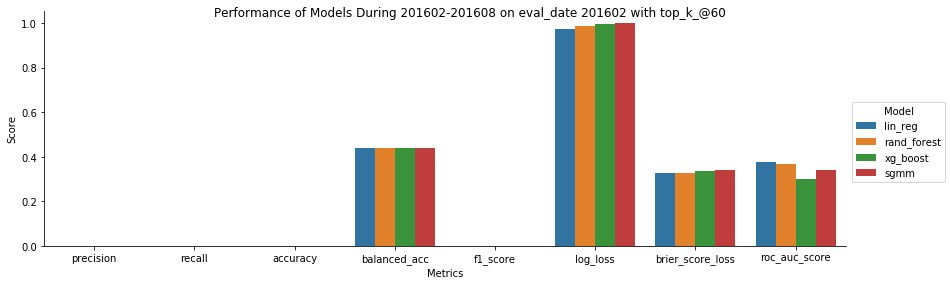

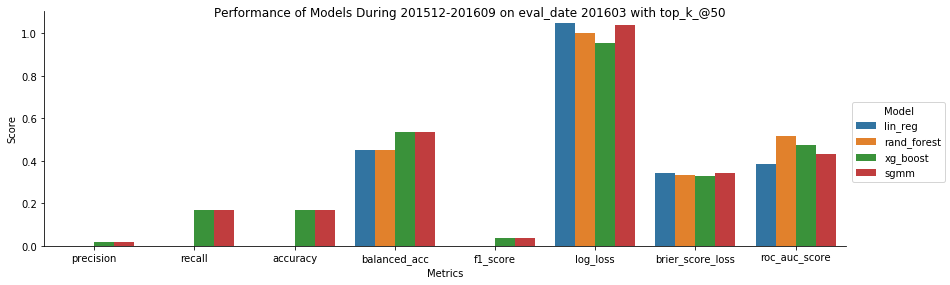

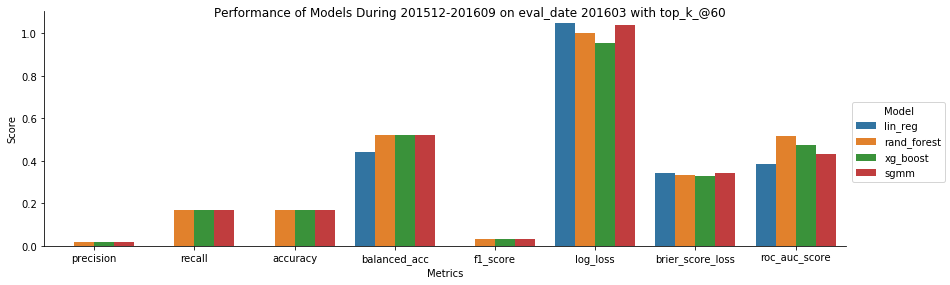

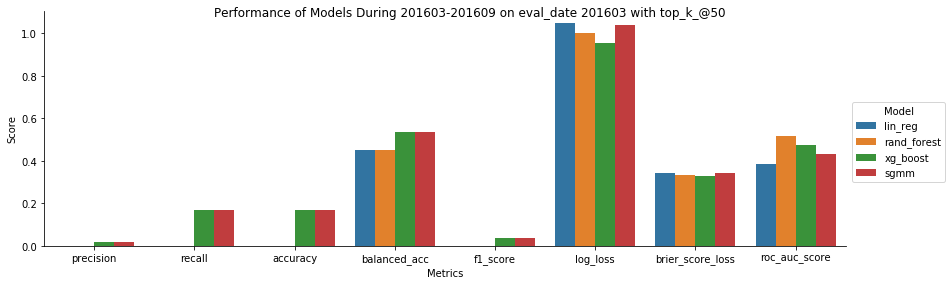

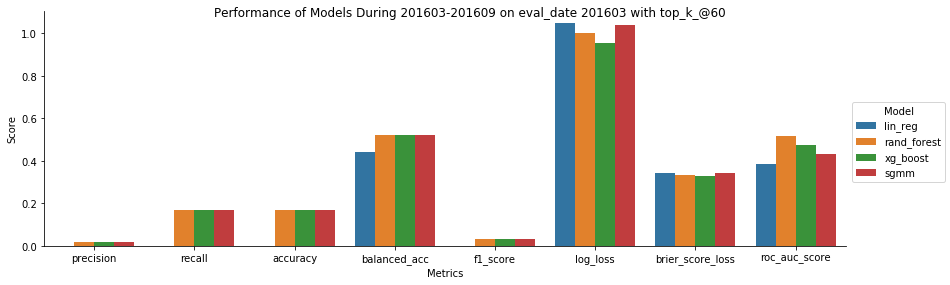

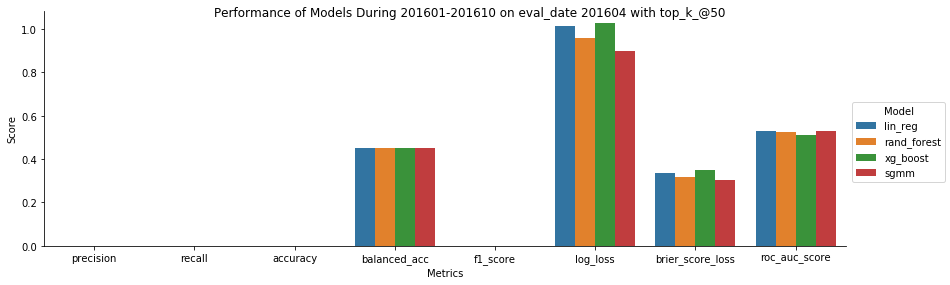

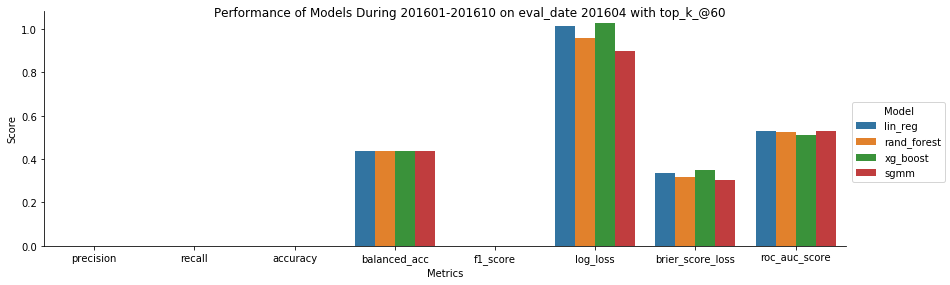

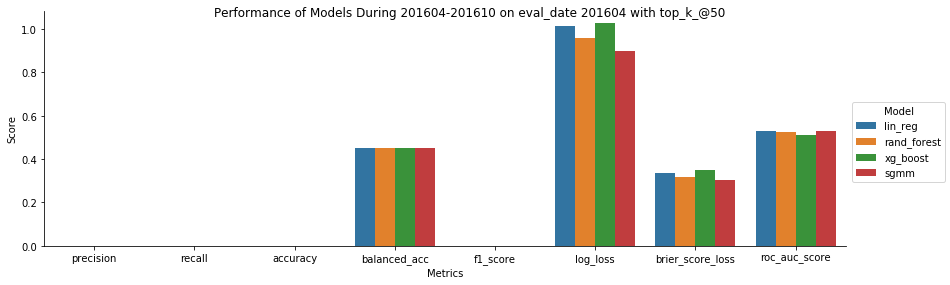

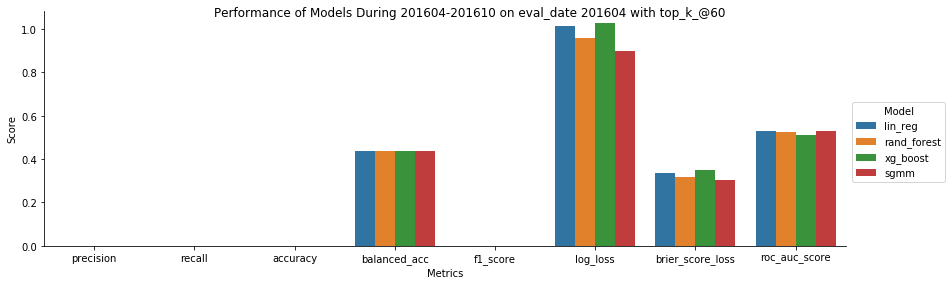

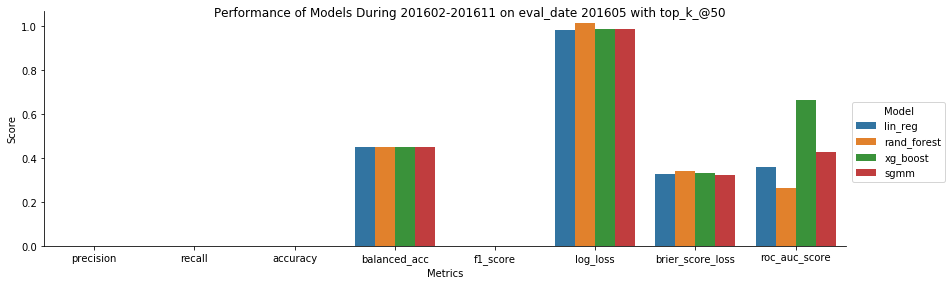

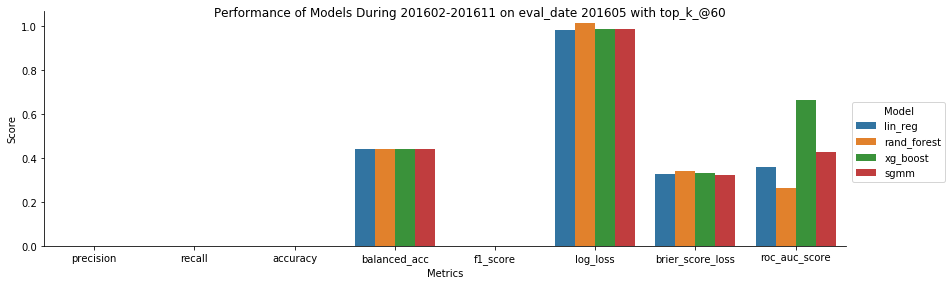

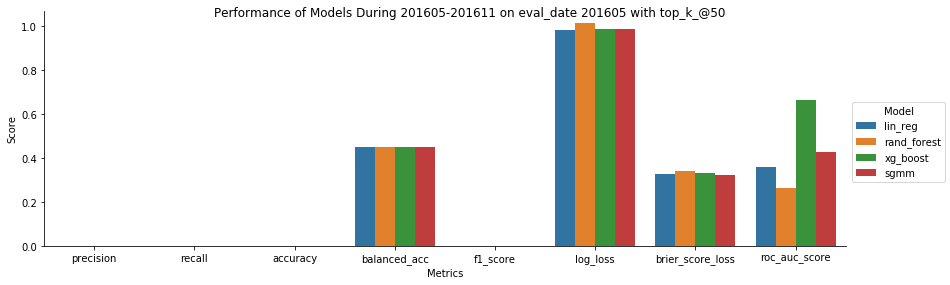

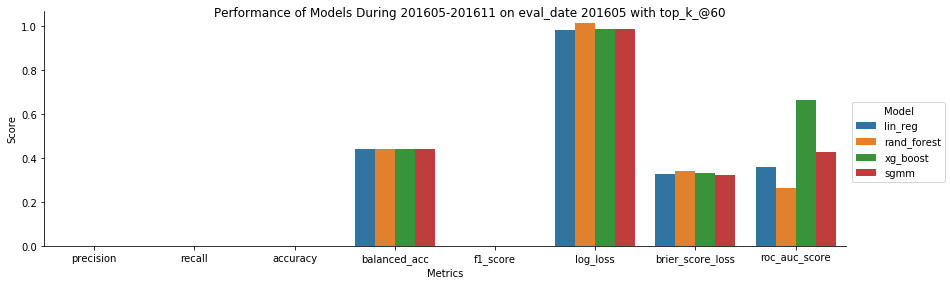

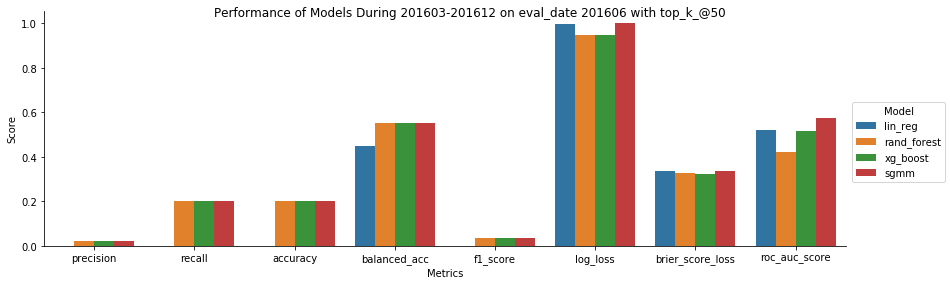

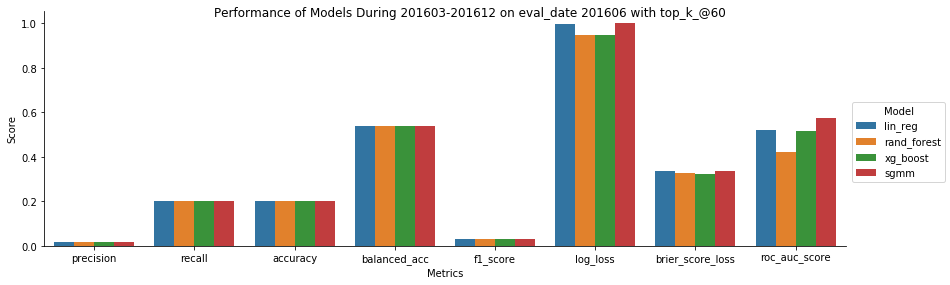

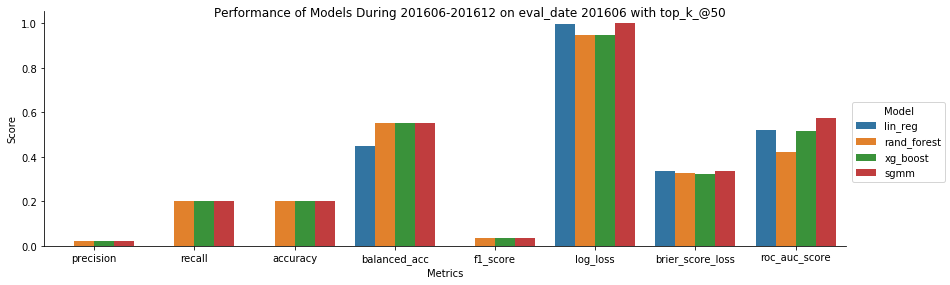

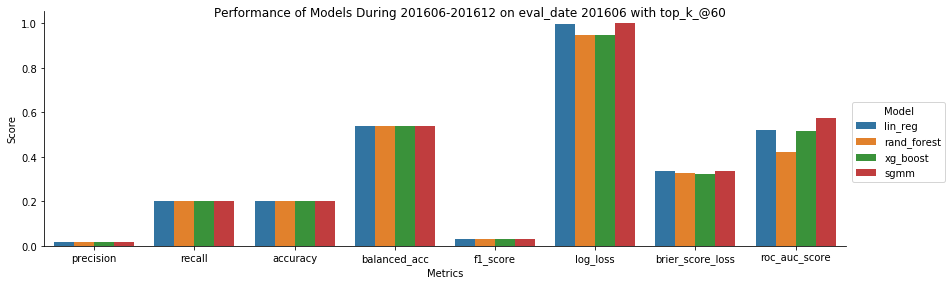

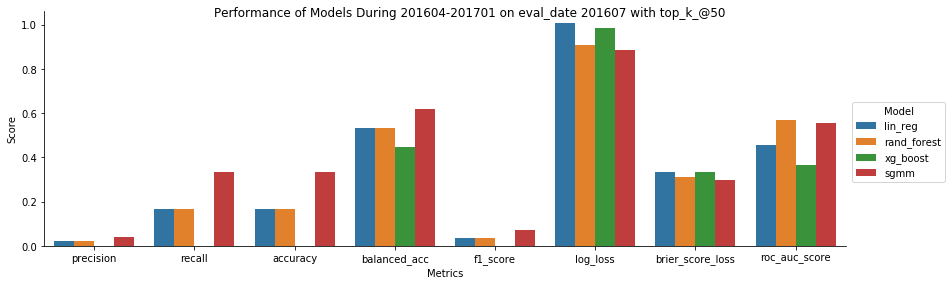

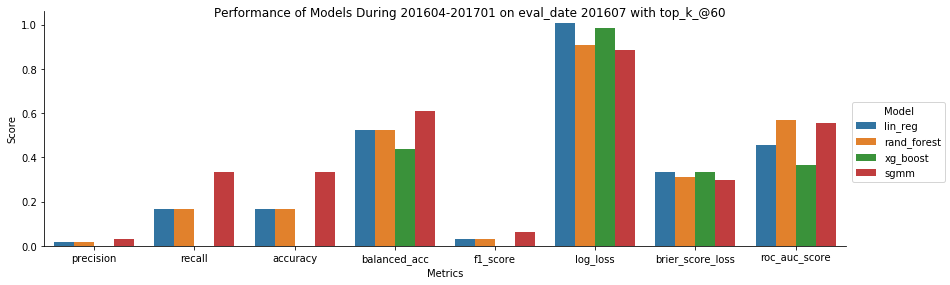

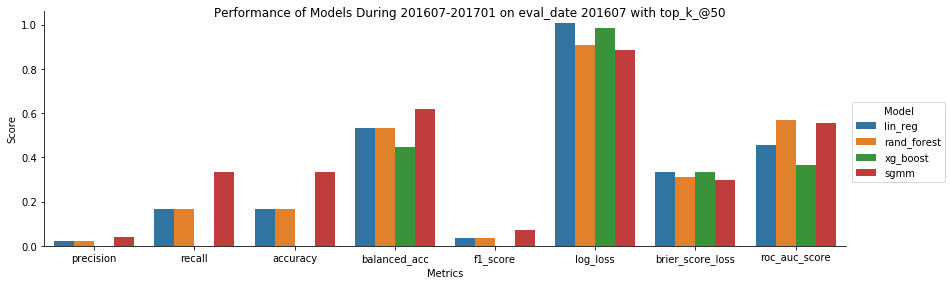

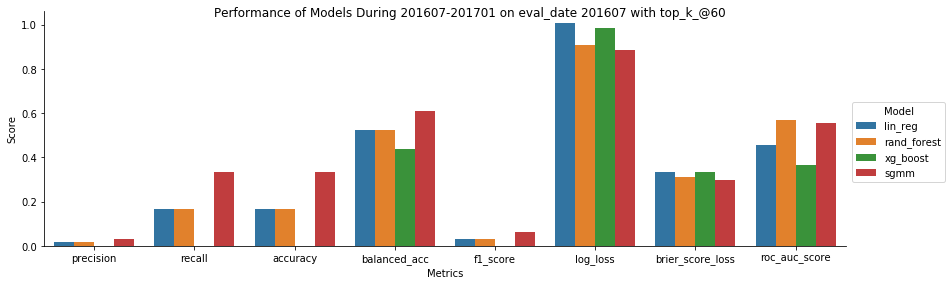

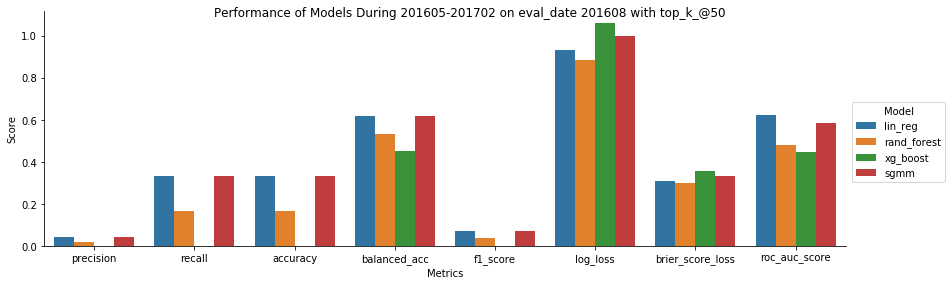

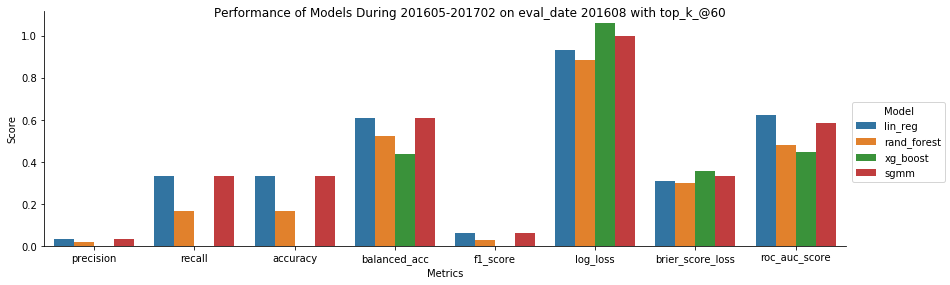

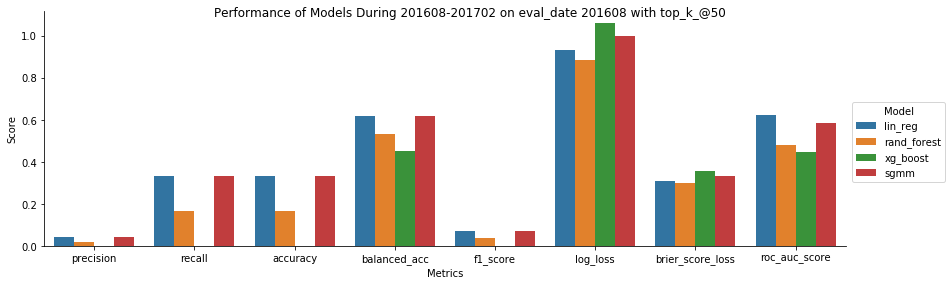

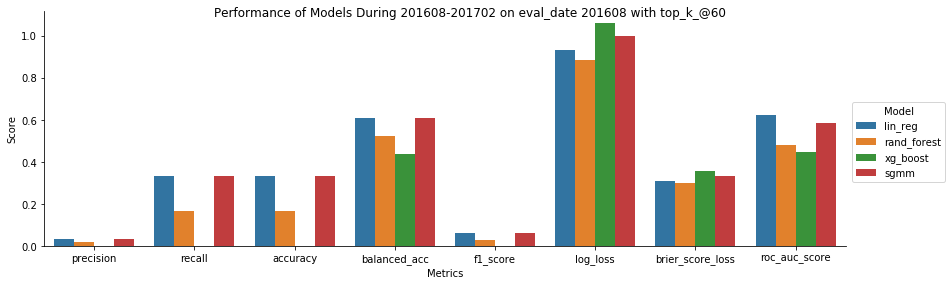

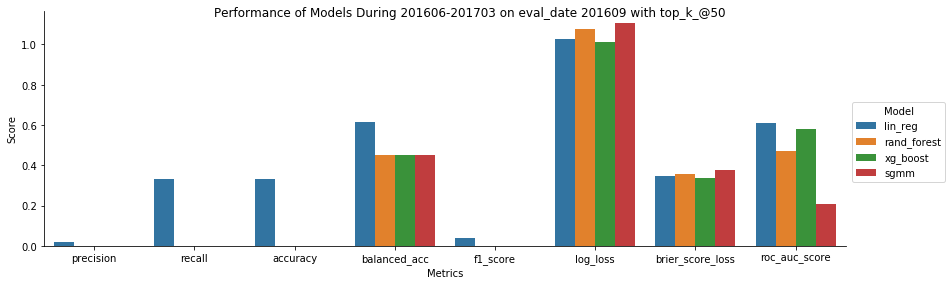

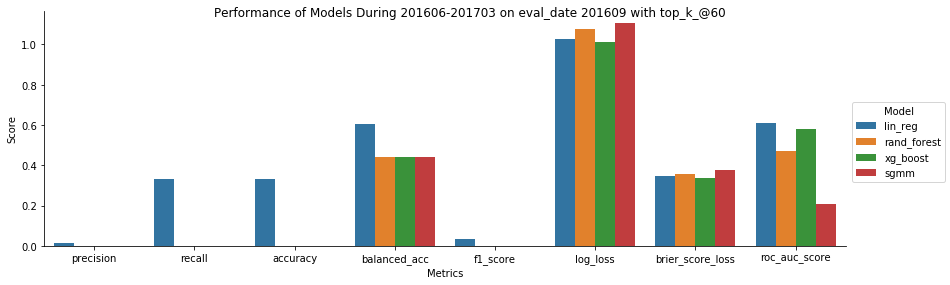

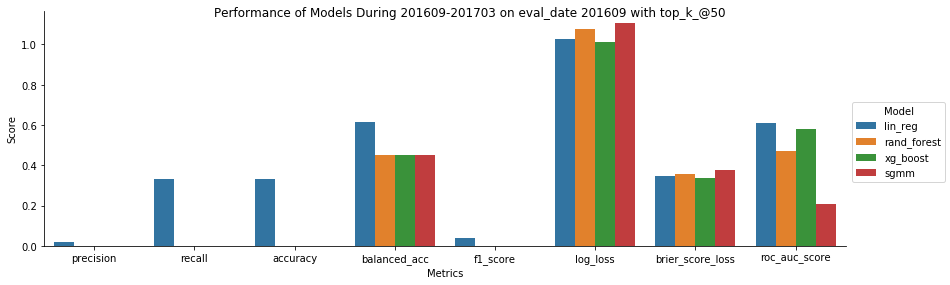

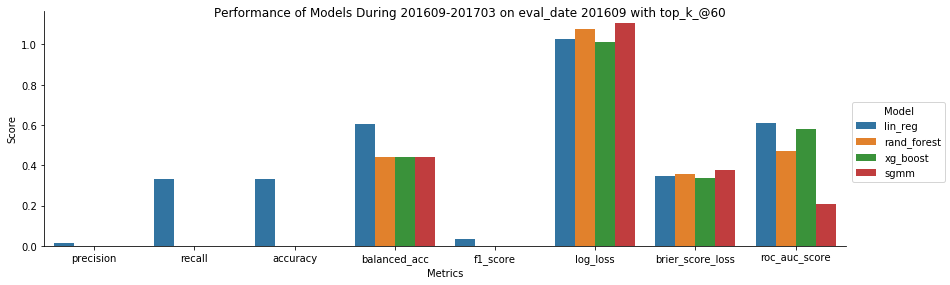

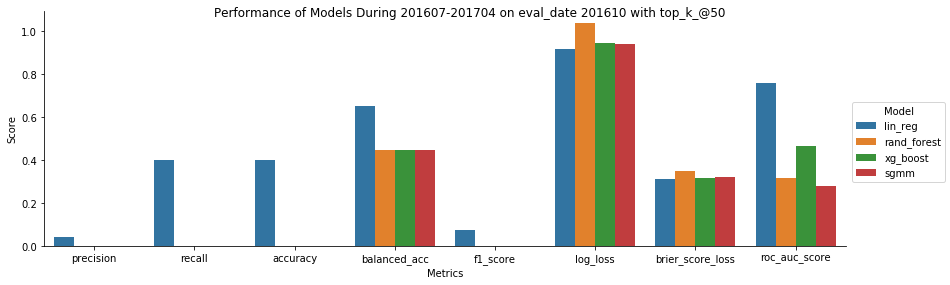

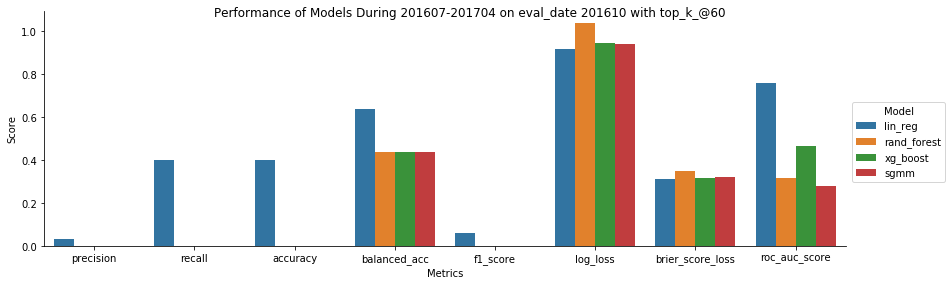

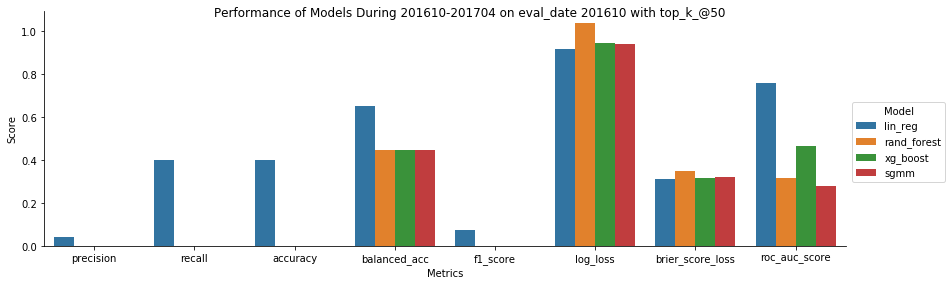

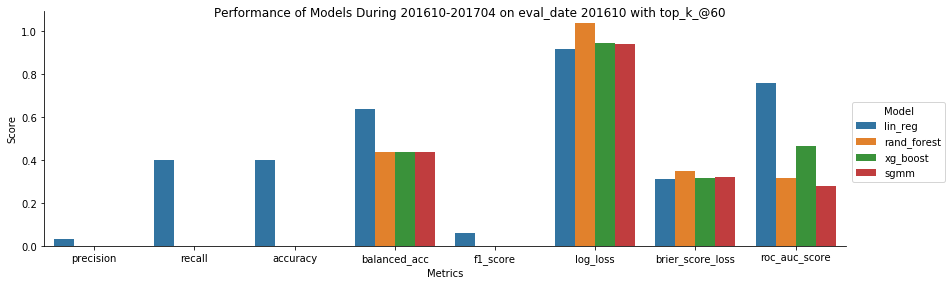

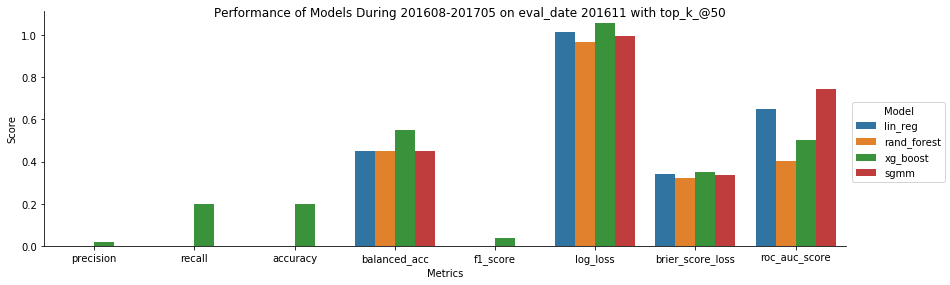

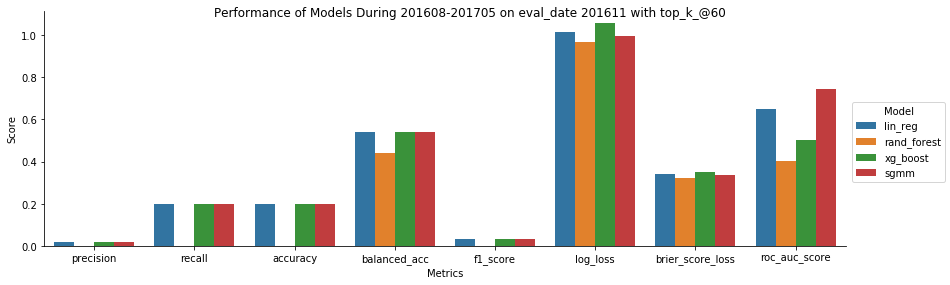

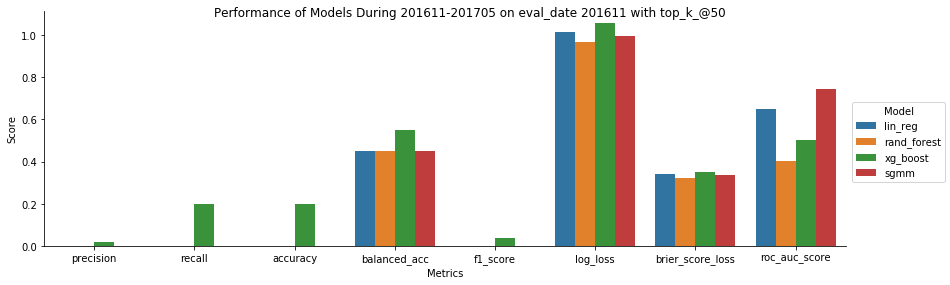

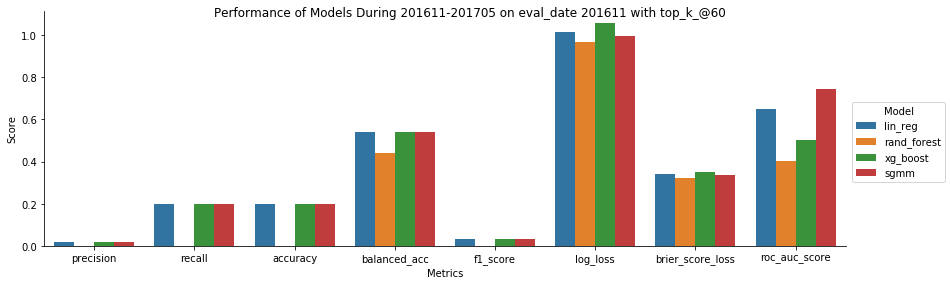

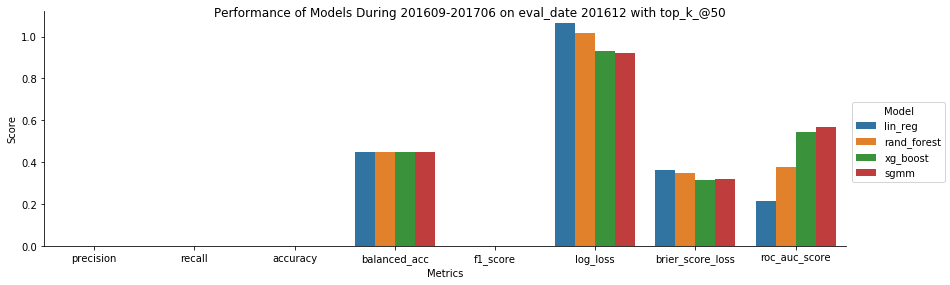

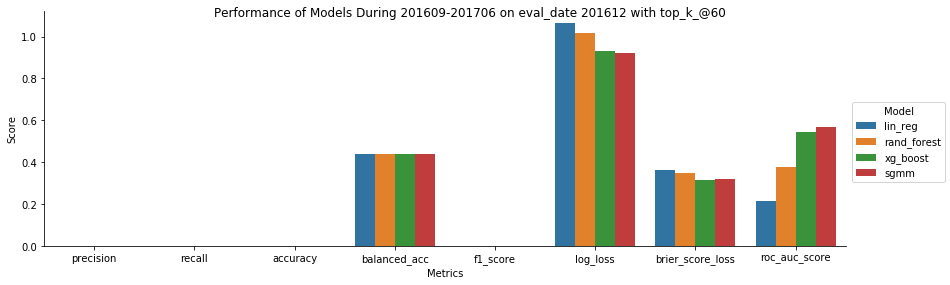

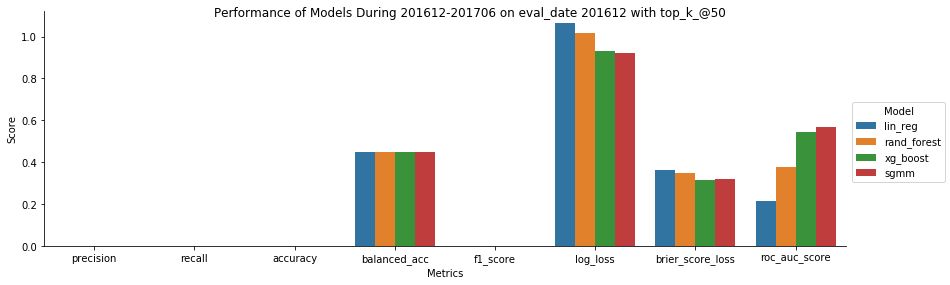

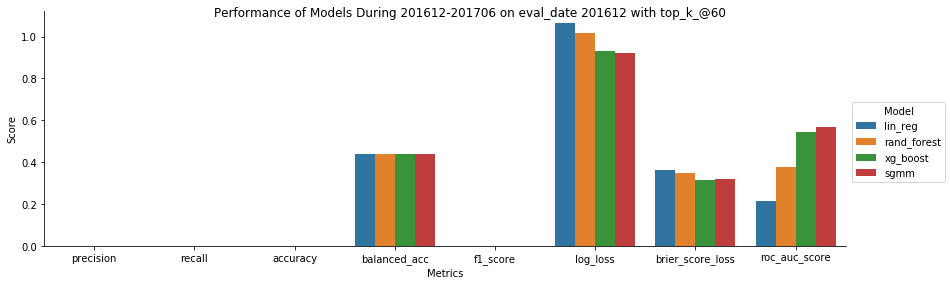

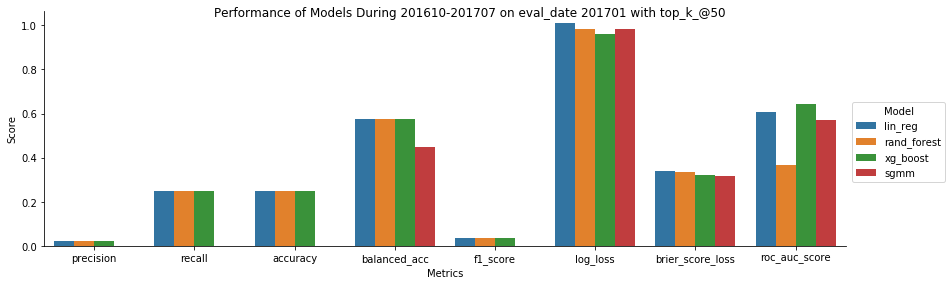

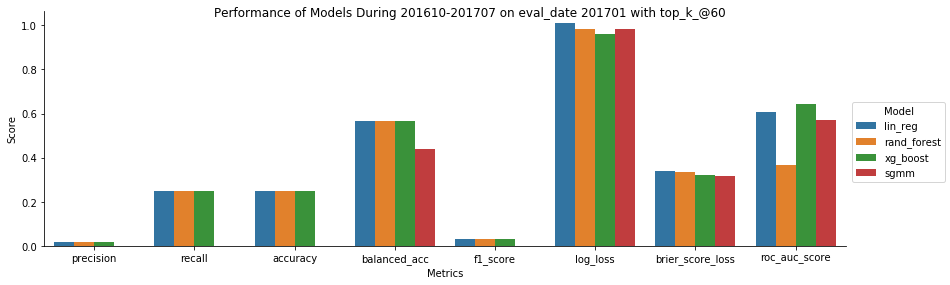

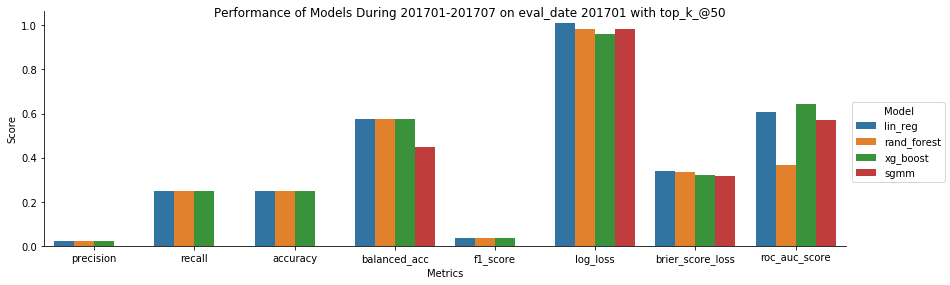

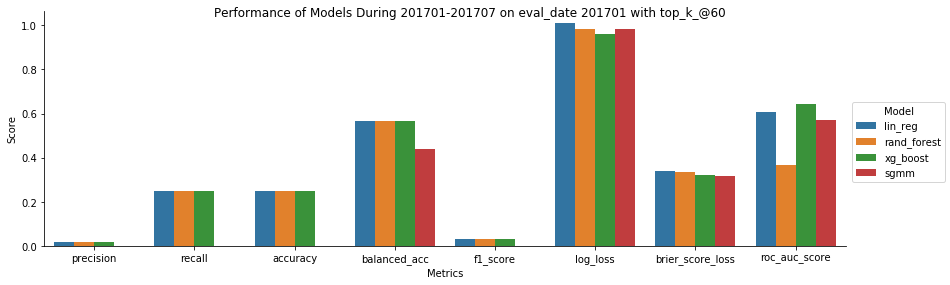

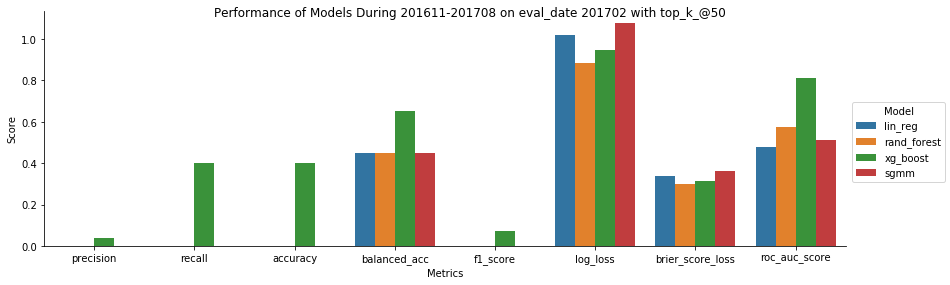

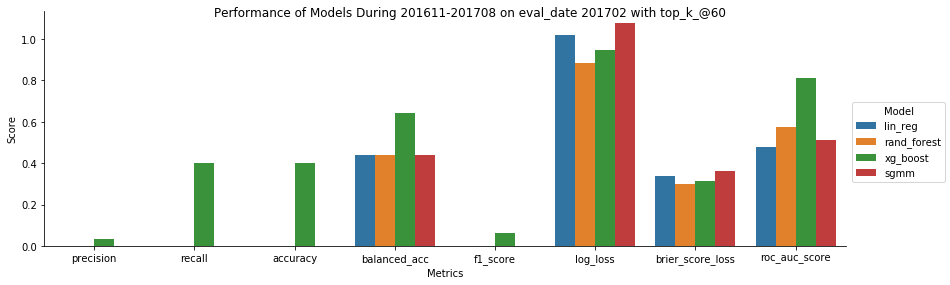

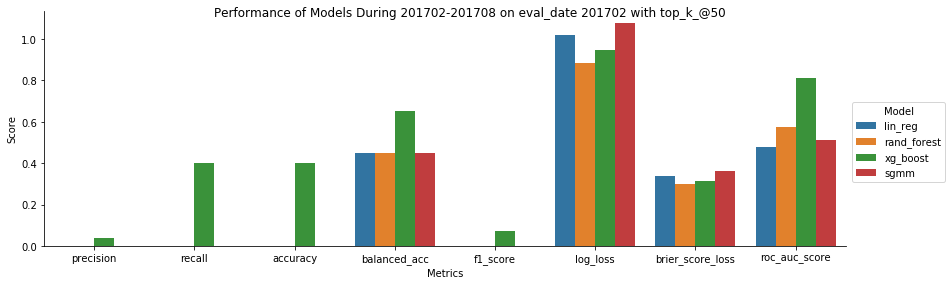

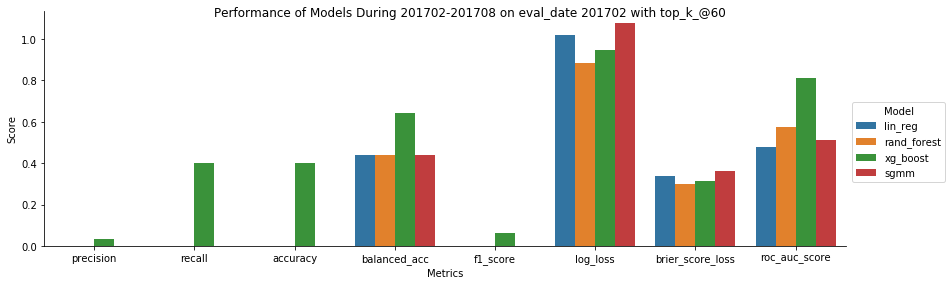

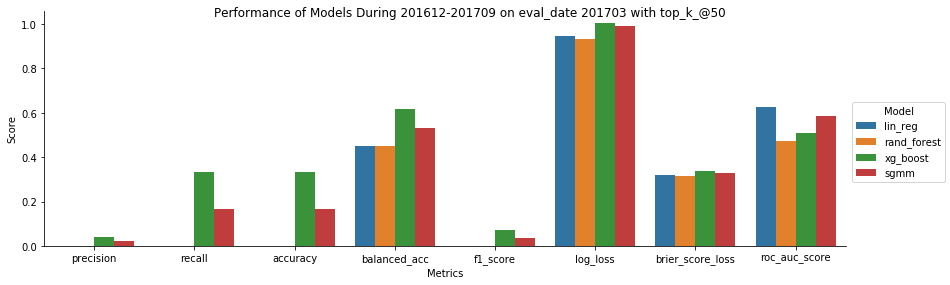

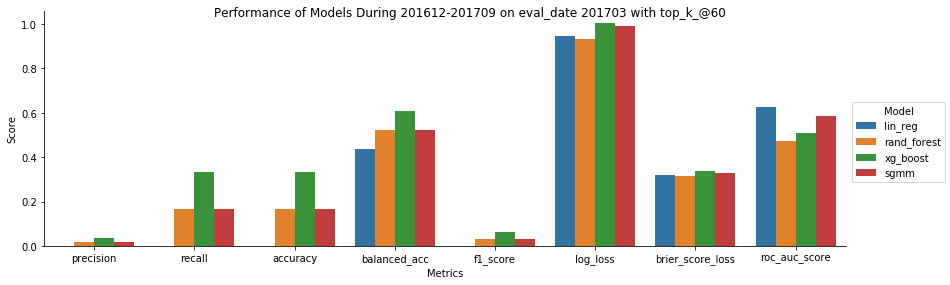

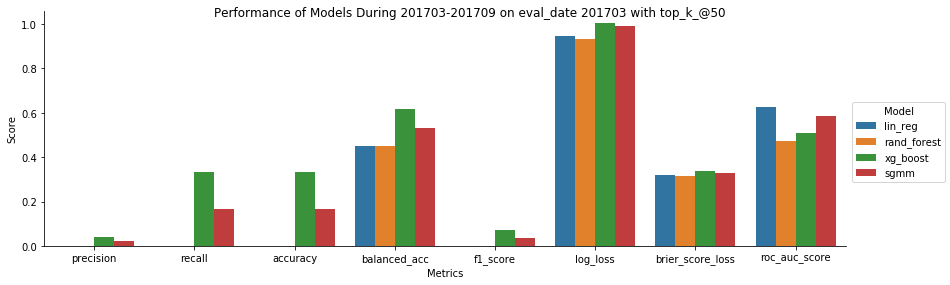

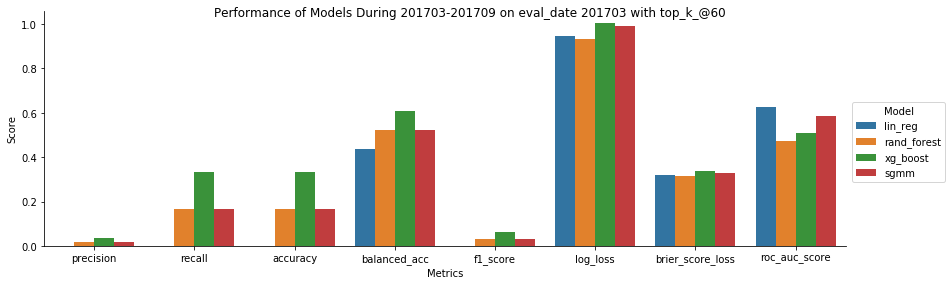

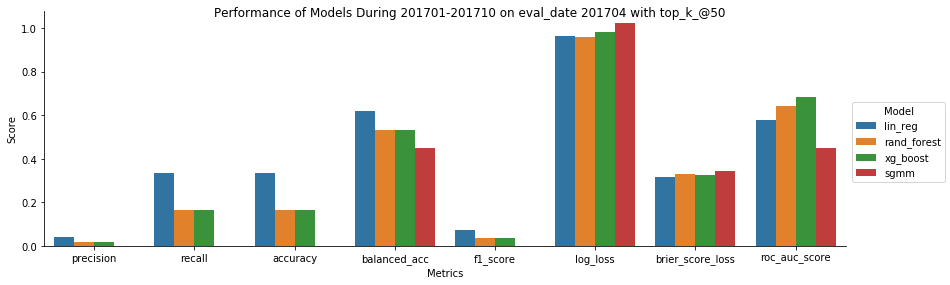

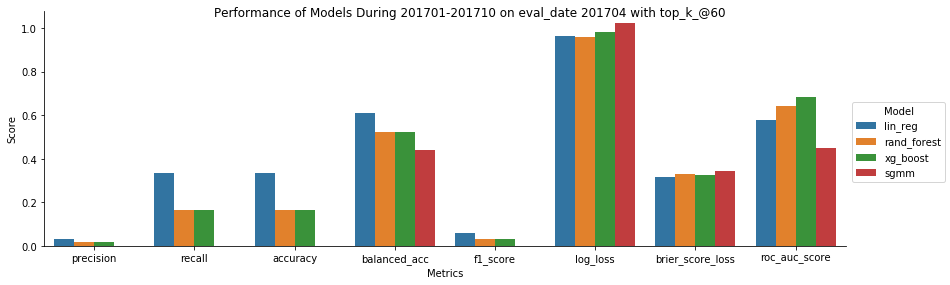

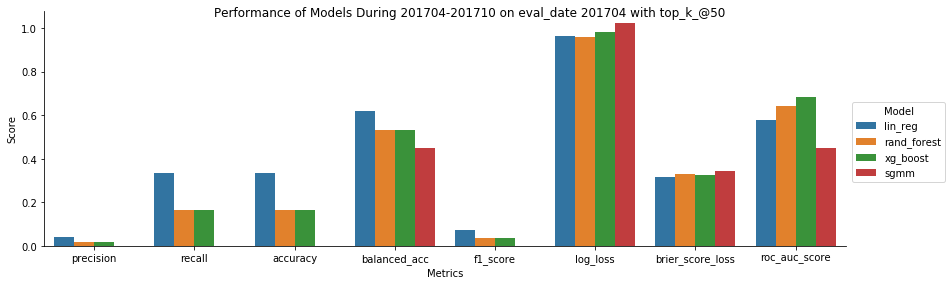

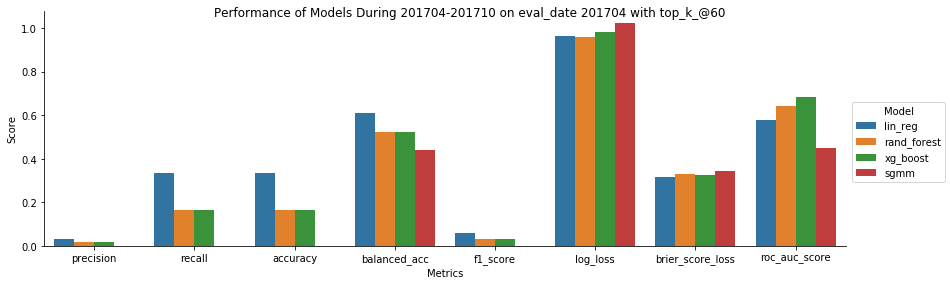

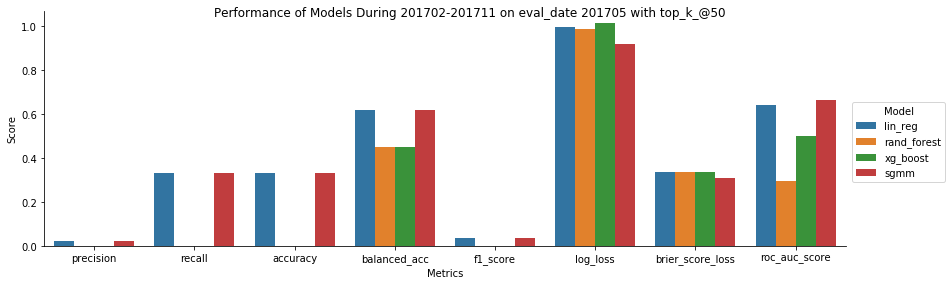

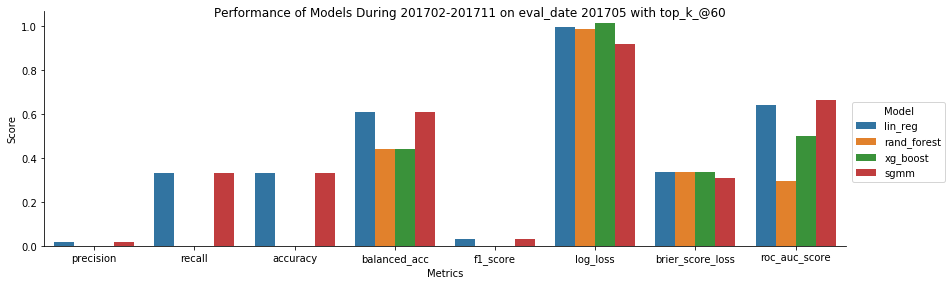

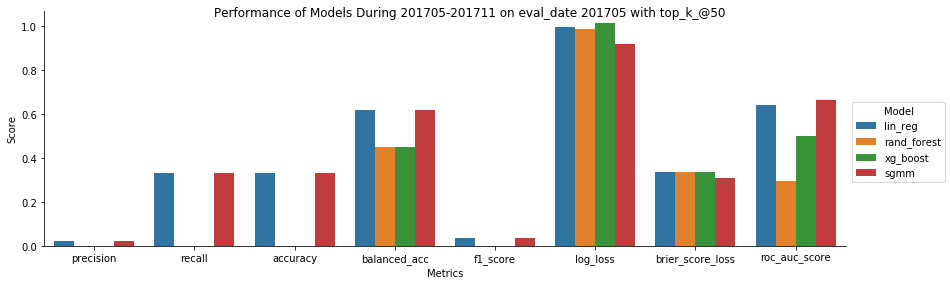

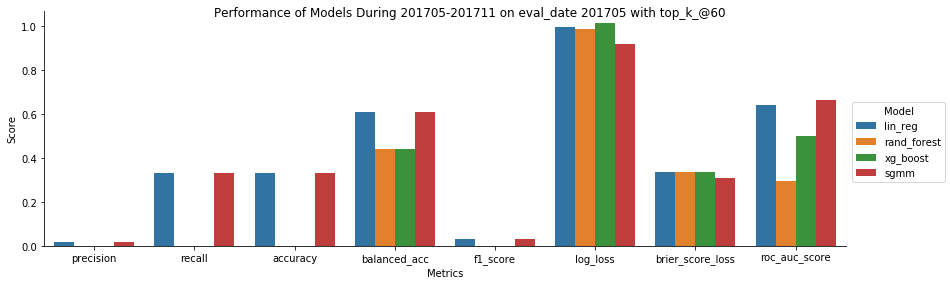

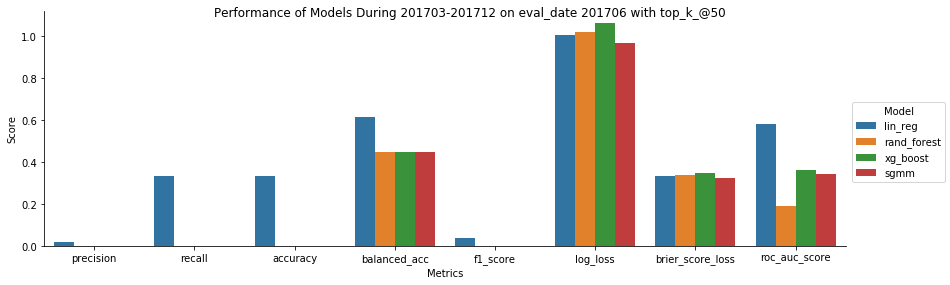

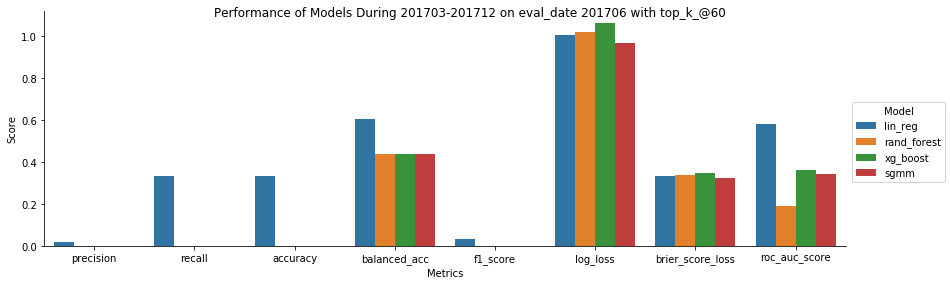

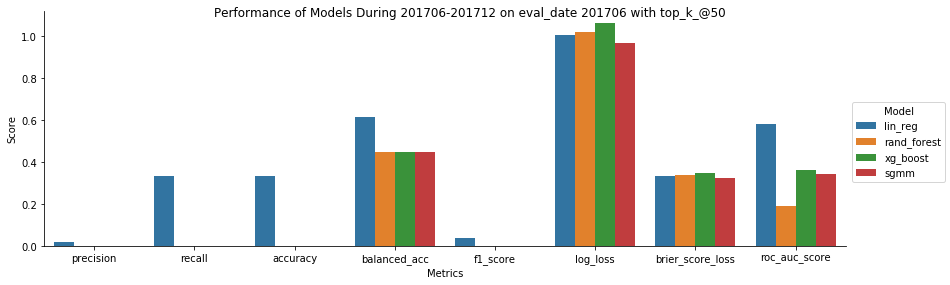

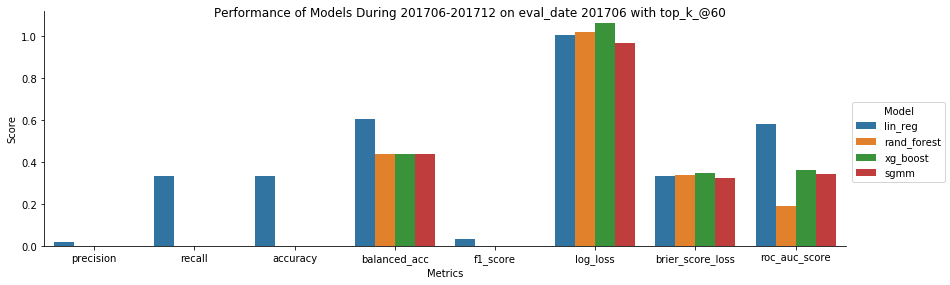

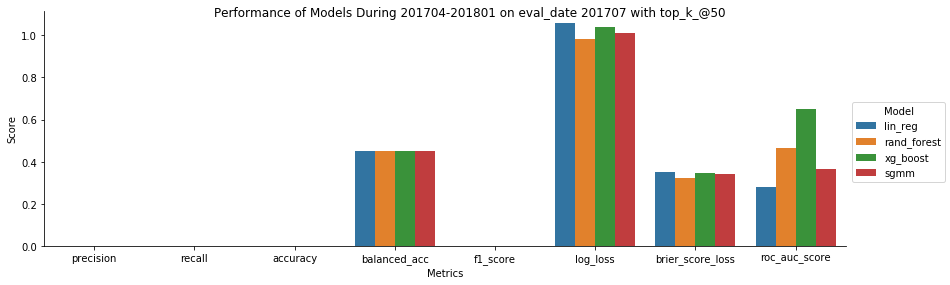

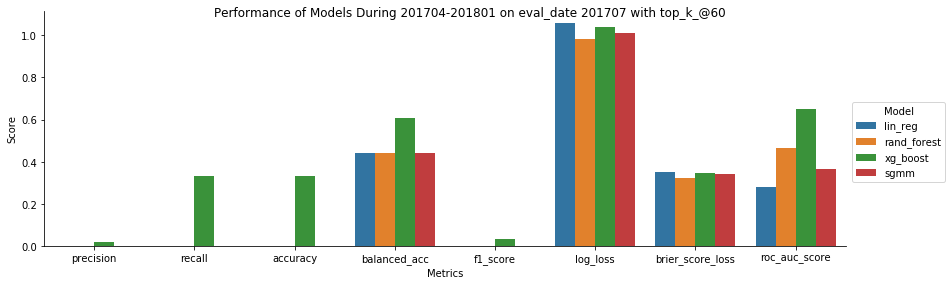

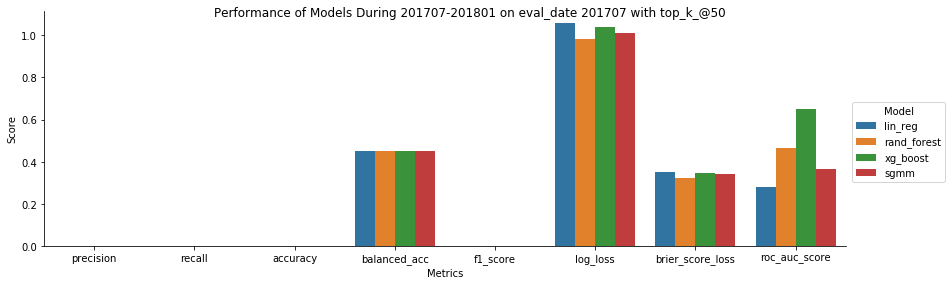

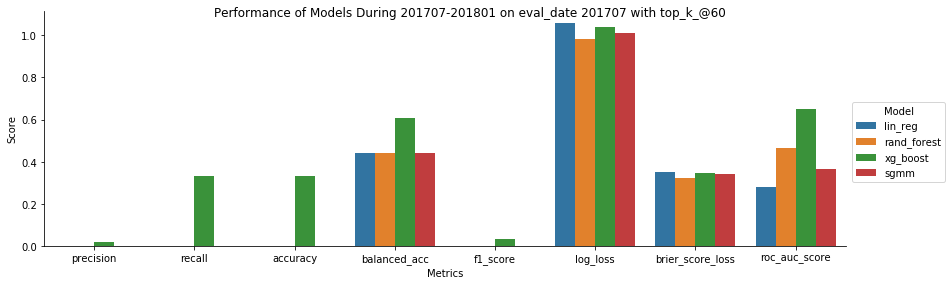

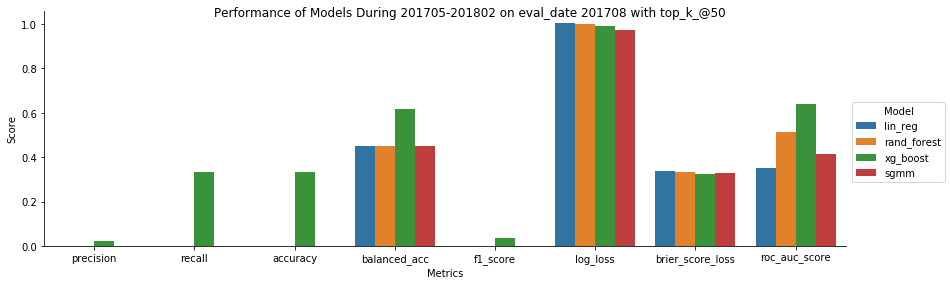

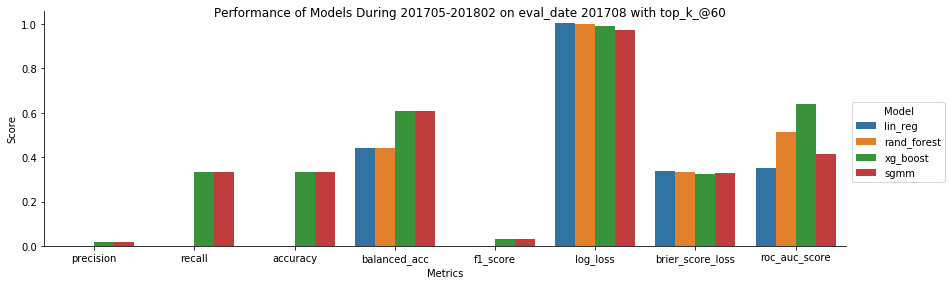

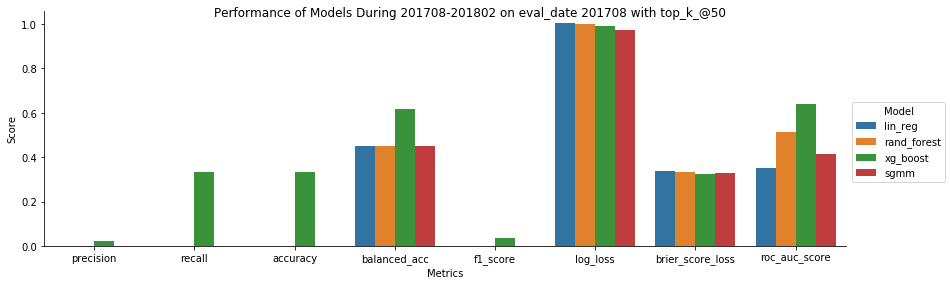

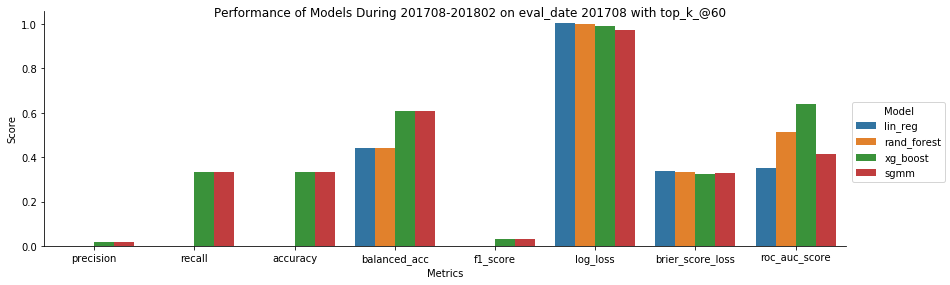

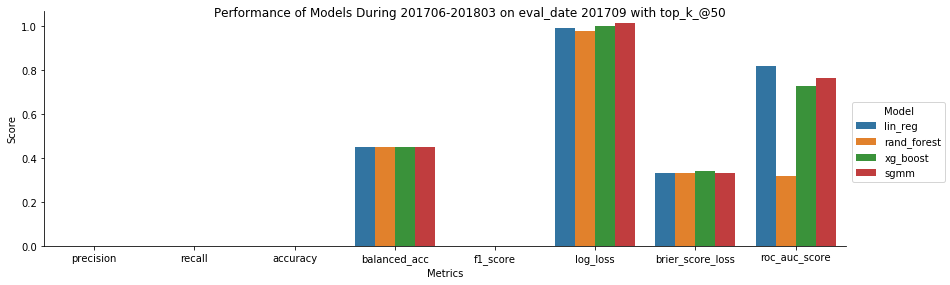

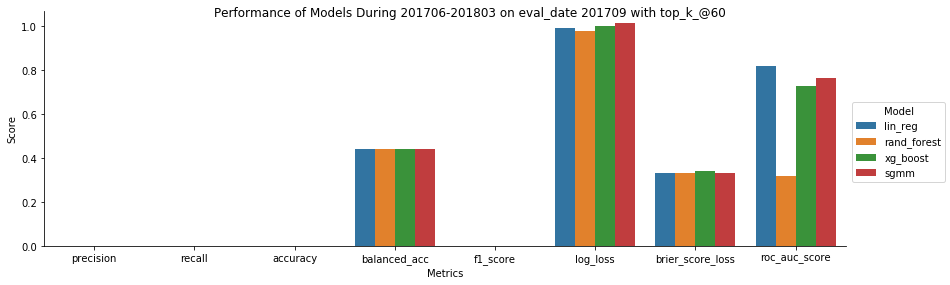

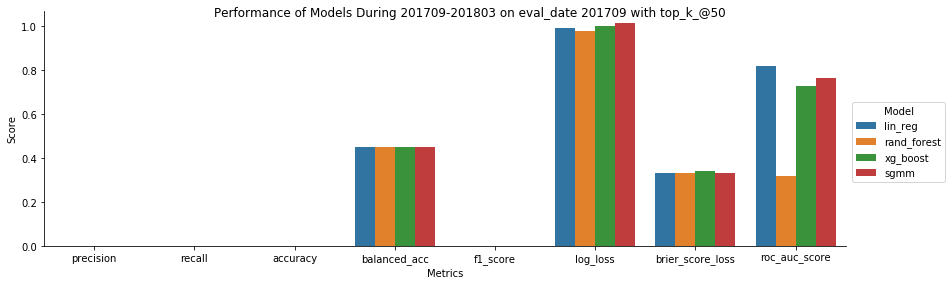

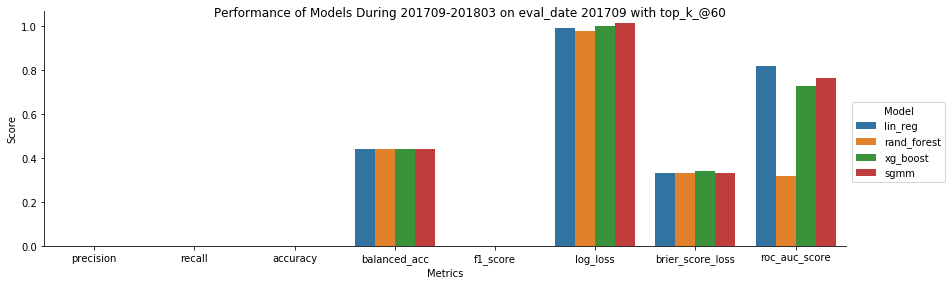

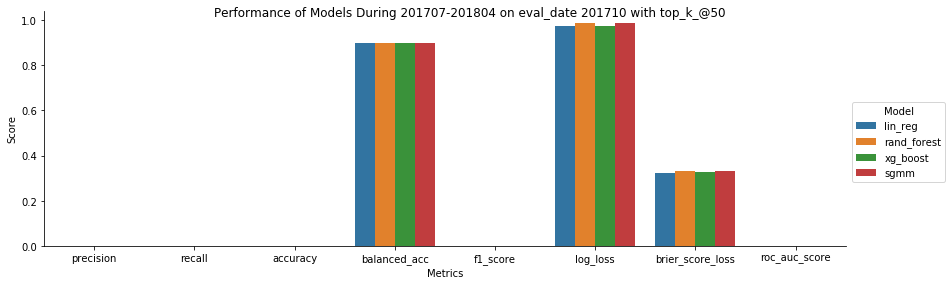

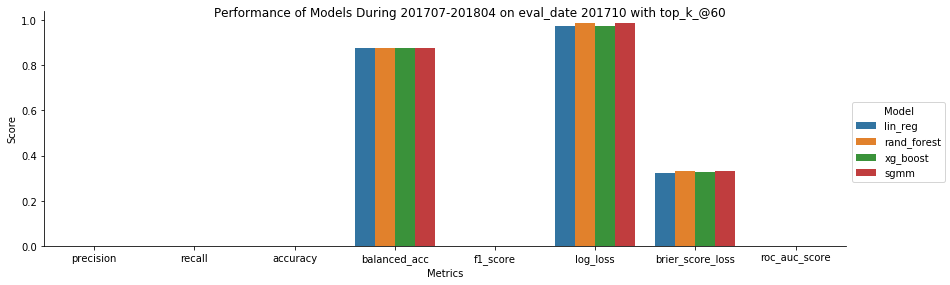

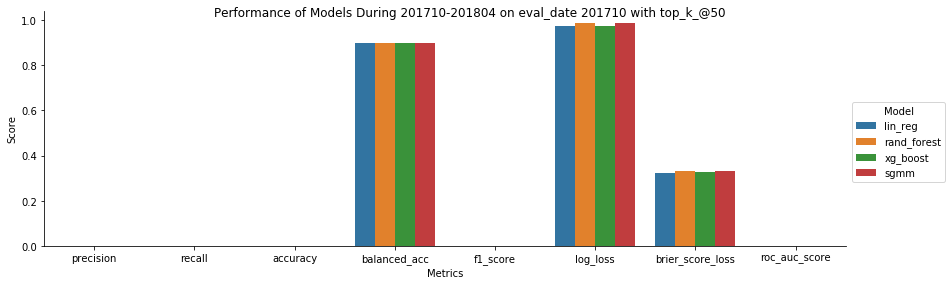

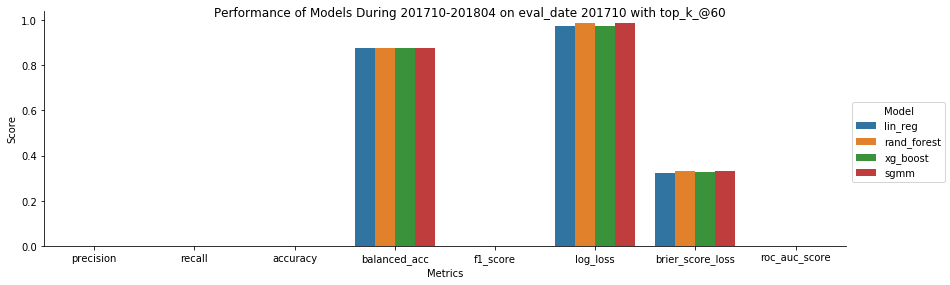

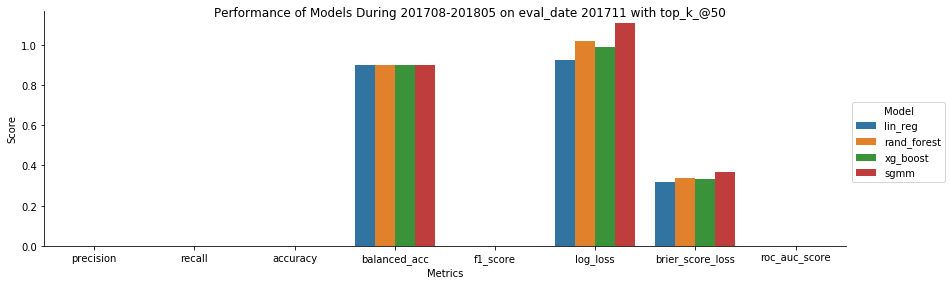

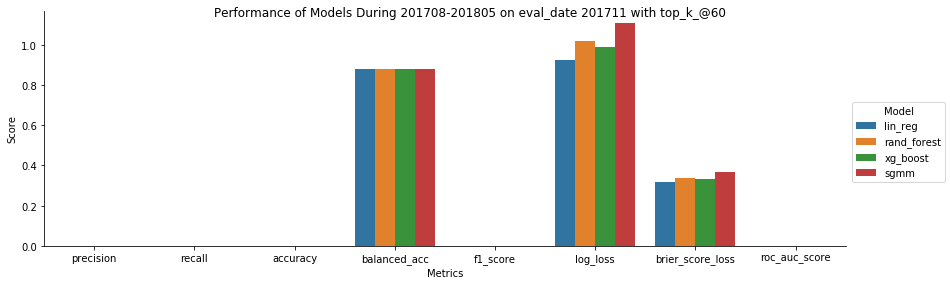

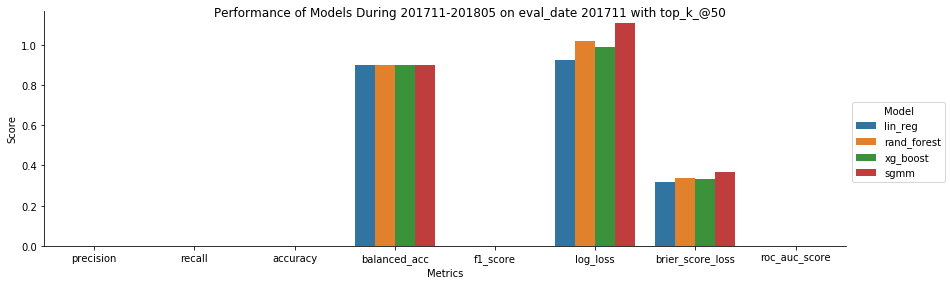

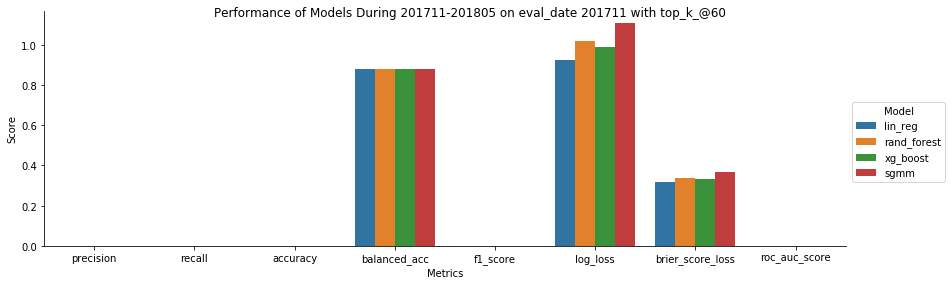

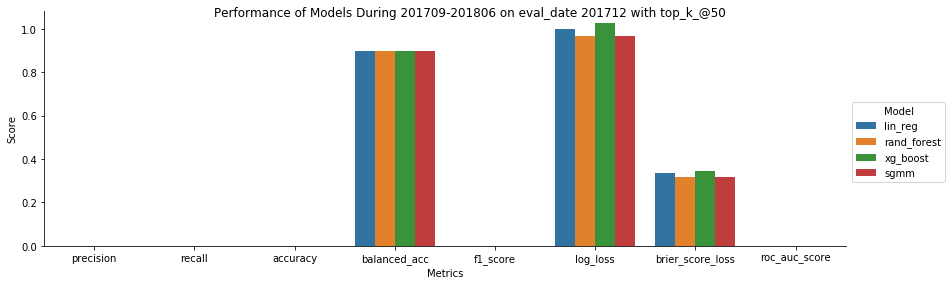

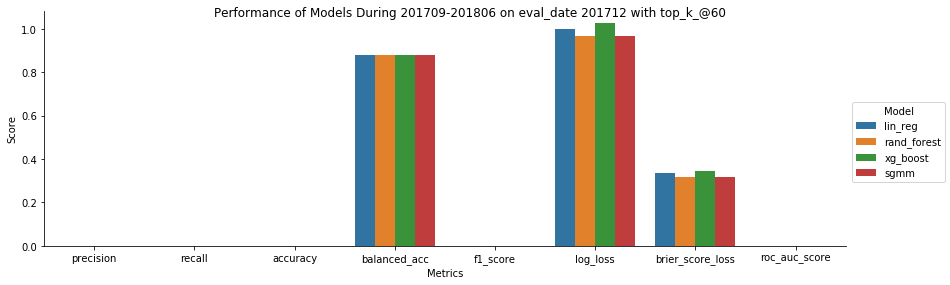

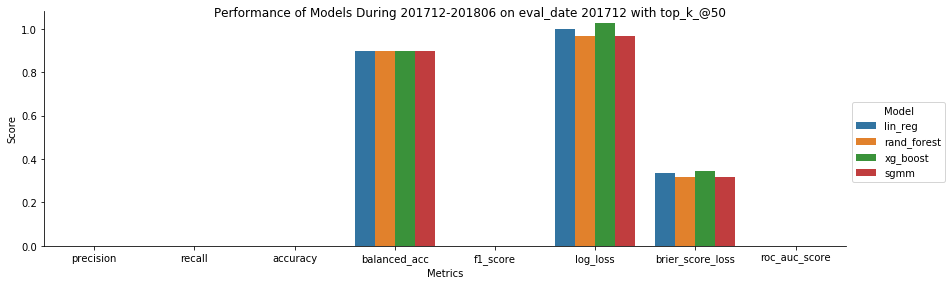

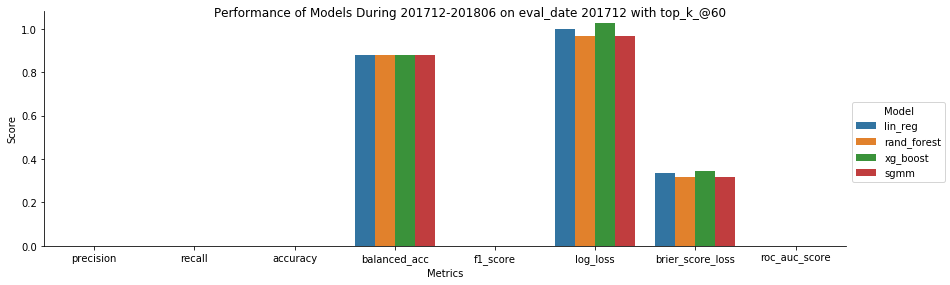

In [18]:
for c_p in predictions:    
    prediction=Helper.read_file(directory=c_p['dir'],file=c_p['file'],file_format=c_p['file_format'],aws=c_p['aws'],bucket= c_p['bucket'])
    referrals=Helper.read_file(directory=c_r['dir'],file=c_r['file'],file_format=c_r['file_format'],aws=c_r['aws'],bucket= c_r['bucket'])
    
    #eval date extract
    date_list = Helper.eval_date_extract(c_p, prediction)
    
    #run evaluation for all eval dates
    for eval_date in date_list:
        c_e['eval_date'] = eval_date
        all_model_evaluations = Evaluate.evaluate(c_p, c_e, c_r, referrals, prediction) 
        Present.present_evaluation(c_p, c_r, c_e, c_visual, eval_date, all_model_evaluations)